# Problem Statement

Recognition of traffic signs is a challenging real-world problem of high industrial relevance. Although commercial systems have reached the market and several studies on this topic have been published, systematic unbiased comparisons of different approaches are missing and comprehensive benchmark datasets are not freely available.


Traffic sign recognition is a multi-class classification problem with unbalanced class frequencies. Traffic signs can provide a wide range of variations between classes in terms of color, shape, and the presence of pictograms or text. However, there exist subsets of classes (e. g., speed limit signs) that are very similar to each other.


The classifier has to cope with large variations in visual appearances due to illumination changes, partial occlusions, rotations, weather conditions, etc.


Humans are capable of recognizing the large variety of existing road signs with close to 100% correctness. This does not only apply to real-world driving, which provides both context and multiple views of a single traffic sign, but also to the recognition from single images.



In [1]:
import matplotlib.pyplot as plt
import csv
%matplotlib inline 
from matplotlib import pyplot as plt
import random
import os
import pandas as pd
import math
import numpy as np
import keras
import seaborn as sns
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential
import time
from time import sleep
from tqdm import tqdm_notebook as tq
from skimage import io, color, exposure, transform
#from sklearn.preprocessing import train_test_split
import os
import glob
import h5py
import cv2
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,f1_score,precision_score
from sklearn.metrics import roc_curve,log_loss,auc
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

Using TensorFlow backend.


# Reading the Image Dataset

In [2]:
def resize_cv(im):
    return cv2.resize(im, (64, 64), interpolation = cv2.INTER_LINEAR)

def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    #shuffle all rootpaths
#     all_img_path = glob.glob(os.path.join(rootdir, '*/*.ppm'))
#     rootpath = np.random.shuffle(all_img_path)
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    #rescale to standard size
    img = resize_cv(img)

    # roll color axis to axis 0
#    img = np.rollaxis(img,-1)

    return img



In [3]:
images, labels = readTrafficSigns('E:\\Kaggle\\Traffic Sign Detection Dataset\\GTSRB\\Final_Training\\Images')

In [4]:
print('The Number of Images -', len(images), '\n\nThe Number of Labels -', len(labels), '\n\nThe Number of Unique Labels -', len(list(set(labels))))

The Number of Images - 39209 

The Number of Labels - 39209 

The Number of Unique Labels - 43


In [5]:
pp_images = []
#IMG_SIZE = 64

for image in tq(images):
    pp_images.append(preprocess_img(image))

In [6]:
image_id = random.sample(range(2000), 5)
print(image_id)

[184, 884, 500, 263, 1525]


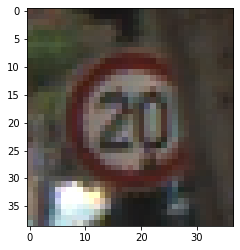

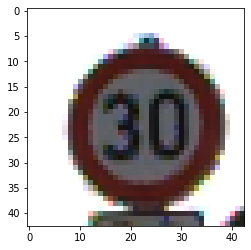

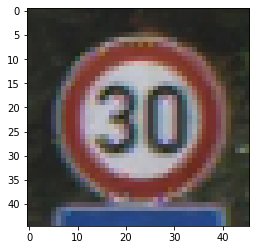

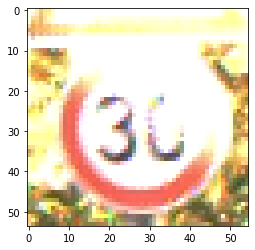

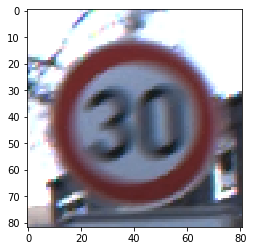

In [7]:
for i in image_id:
    plt.imshow(images[i], interpolation='nearest')
    plt.show()

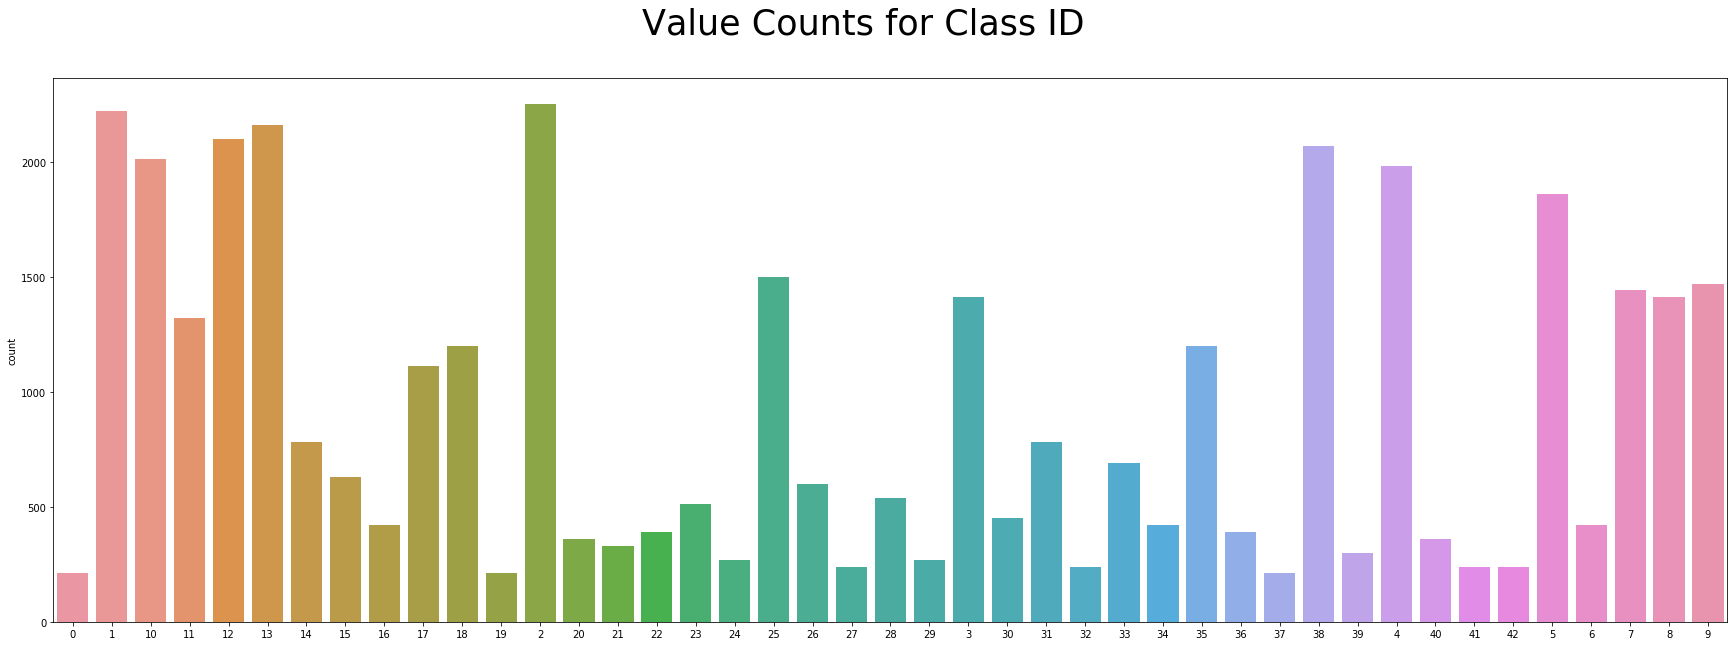

In [8]:
f,ax = plt.subplots(figsize = (30,10))
f.suptitle('Value Counts for Class ID', fontsize = 35)
#print(i['status'].value_counts())
sns.countplot(labels)

In [9]:
input_array = np.stack(pp_images)

train_y = keras.utils.np_utils.to_categorical(labels)

In [10]:
### Randomizing the dataset
randomize = np.arange(len(input_array))
np.random.shuffle(randomize)
x = input_array[randomize]
y = train_y[randomize]

In [11]:
x.shape

(39209, 64, 64, 3)

In [12]:
split_size = int(x.shape[0]*0.6)
train_x, val_x = x[:split_size], x[split_size:]
train1_y, val_y = y[:split_size], y[split_size:]

In [13]:
split_size = int(val_x.shape[0]*0.5)
val_x, test_x = val_x[:split_size], val_x[split_size:]
val_y, test_y = val_y[:split_size], val_y[split_size:]

In [14]:
### Building the model
hidden_num_units = 2048
hidden_num_units1 = 1024
hidden_num_units2 = 128
output_num_units = 43

epochs = 10
batch_size = 16
pool_size = (2, 2)
input_shape = Input(shape=(32, 32,3))

model = Sequential([

 Conv2D(16, (3, 3), activation='relu', input_shape=(64,64,3), padding='same'),
 BatchNormalization(),

 Conv2D(16, (3, 3), activation='relu', padding='same'),
 BatchNormalization(),
 MaxPooling2D(pool_size=pool_size),
 Dropout(0.2),
    
 Conv2D(32, (3, 3), activation='relu', padding='same'),
 BatchNormalization(),
    
 Conv2D(32, (3, 3), activation='relu', padding='same'),
 BatchNormalization(),
 MaxPooling2D(pool_size=pool_size),
 Dropout(0.2),
    
 Conv2D(64, (3, 3), activation='relu', padding='same'),
 BatchNormalization(),
    
 Conv2D(64, (3, 3), activation='relu', padding='same'),
 BatchNormalization(),
 MaxPooling2D(pool_size=pool_size),
 Dropout(0.2),

 Flatten(),

 Dense(units=hidden_num_units, activation='relu'),
 Dropout(0.3),
 Dense(units=hidden_num_units1, activation='relu'),
 Dropout(0.3),
 Dense(units=hidden_num_units2, activation='relu'),
 Dropout(0.3),
 Dense(units=output_num_units, input_dim=hidden_num_units, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])


In [15]:
### Training the model
history = trained_model_conv = model.fit(train_x.reshape(-1,64,64,3), train1_y, epochs=epochs, batch_size=batch_size, validation_data=(val_x, val_y))

Train on 23525 samples, validate on 7842 samples
Epoch 1/10


 2928/23525 [==>...........................] - ETA: 1:18:53 - loss: 5.6564 - accuracy: 0.0000e+0 - ETA: 40:44 - loss: 5.3110 - accuracy: 0.0000e+00  - ETA: 28:02 - loss: 5.1570 - accuracy: 0.0000e+0 - ETA: 21:40 - loss: 5.2497 - accuracy: 0.0000e+0 - ETA: 17:51 - loss: 5.1386 - accuracy: 0.0250    - ETA: 15:18 - loss: 5.0342 - accuracy: 0.031 - ETA: 13:29 - loss: 5.1138 - accuracy: 0.026 - ETA: 12:08 - loss: 5.0423 - accuracy: 0.031 - ETA: 11:04 - loss: 4.9679 - accuracy: 0.027 - ETA: 10:13 - loss: 4.9485 - accuracy: 0.025 - ETA: 9:32 - loss: 4.9251 - accuracy: 0.022 - ETA: 8:57 - loss: 4.8884 - accuracy: 0.02 - ETA: 8:27 - loss: 4.8544 - accuracy: 0.02 - ETA: 8:02 - loss: 4.8400 - accuracy: 0.02 - ETA: 7:41 - loss: 4.7710 - accuracy: 0.03 - ETA: 7:21 - loss: 4.7596 - accuracy: 0.03 - ETA: 7:04 - loss: 4.7117 - accuracy: 0.04 - ETA: 6:49 - loss: 4.6833 - accuracy: 0.03 - ETA: 6:36 - loss: 4.6411 - accuracy: 0.03 - ETA: 6:24 - loss: 4.6222 - accuracy: 0.04 - ETA: 6:13 - loss: 4.5952 - a

 5904/23525 [======>.......................] - ETA: 4:38 - loss: 3.8166 - accuracy: 0.06 - ETA: 4:38 - loss: 3.8137 - accuracy: 0.06 - ETA: 4:38 - loss: 3.8146 - accuracy: 0.06 - ETA: 4:38 - loss: 3.8118 - accuracy: 0.06 - ETA: 4:38 - loss: 3.8118 - accuracy: 0.06 - ETA: 4:38 - loss: 3.8100 - accuracy: 0.06 - ETA: 4:38 - loss: 3.8097 - accuracy: 0.06 - ETA: 4:38 - loss: 3.8100 - accuracy: 0.06 - ETA: 4:38 - loss: 3.8078 - accuracy: 0.06 - ETA: 4:39 - loss: 3.8076 - accuracy: 0.06 - ETA: 4:39 - loss: 3.8058 - accuracy: 0.06 - ETA: 4:39 - loss: 3.8027 - accuracy: 0.06 - ETA: 4:39 - loss: 3.7996 - accuracy: 0.06 - ETA: 4:39 - loss: 3.7971 - accuracy: 0.06 - ETA: 4:39 - loss: 3.7944 - accuracy: 0.06 - ETA: 4:39 - loss: 3.7937 - accuracy: 0.06 - ETA: 4:39 - loss: 3.7897 - accuracy: 0.06 - ETA: 4:39 - loss: 3.7892 - accuracy: 0.06 - ETA: 4:39 - loss: 3.7881 - accuracy: 0.06 - ETA: 4:39 - loss: 3.7863 - accuracy: 0.06 - ETA: 4:39 - loss: 3.7814 - accuracy: 0.06 - ETA: 4:39 - loss: 3.7793 - ac

 8880/23525 [==========>...................] - ETA: 4:25 - loss: 3.5769 - accuracy: 0.10 - ETA: 4:25 - loss: 3.5757 - accuracy: 0.10 - ETA: 4:24 - loss: 3.5739 - accuracy: 0.10 - ETA: 4:24 - loss: 3.5718 - accuracy: 0.10 - ETA: 4:24 - loss: 3.5710 - accuracy: 0.10 - ETA: 4:24 - loss: 3.5706 - accuracy: 0.10 - ETA: 4:24 - loss: 3.5701 - accuracy: 0.10 - ETA: 4:23 - loss: 3.5689 - accuracy: 0.10 - ETA: 4:23 - loss: 3.5660 - accuracy: 0.10 - ETA: 4:23 - loss: 3.5637 - accuracy: 0.10 - ETA: 4:23 - loss: 3.5623 - accuracy: 0.10 - ETA: 4:23 - loss: 3.5618 - accuracy: 0.10 - ETA: 4:23 - loss: 3.5603 - accuracy: 0.10 - ETA: 4:22 - loss: 3.5574 - accuracy: 0.10 - ETA: 4:22 - loss: 3.5576 - accuracy: 0.10 - ETA: 4:22 - loss: 3.5572 - accuracy: 0.10 - ETA: 4:22 - loss: 3.5561 - accuracy: 0.10 - ETA: 4:22 - loss: 3.5539 - accuracy: 0.10 - ETA: 4:22 - loss: 3.5530 - accuracy: 0.10 - ETA: 4:21 - loss: 3.5536 - accuracy: 0.10 - ETA: 4:21 - loss: 3.5545 - accuracy: 0.10 - ETA: 4:21 - loss: 3.5514 - ac

11856/23525 [==============>...............] - ETA: 3:47 - loss: 3.3545 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3538 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3532 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3517 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3507 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3504 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3487 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3474 - accuracy: 0.14 - ETA: 3:45 - loss: 3.3459 - accuracy: 0.14 - ETA: 3:45 - loss: 3.3445 - accuracy: 0.14 - ETA: 3:45 - loss: 3.3444 - accuracy: 0.14 - ETA: 3:45 - loss: 3.3433 - accuracy: 0.14 - ETA: 3:45 - loss: 3.3421 - accuracy: 0.14 - ETA: 3:44 - loss: 3.3409 - accuracy: 0.14 - ETA: 3:44 - loss: 3.3404 - accuracy: 0.14 - ETA: 3:44 - loss: 3.3404 - accuracy: 0.14 - ETA: 3:44 - loss: 3.3401 - accuracy: 0.14 - ETA: 3:43 - loss: 3.3390 - accuracy: 0.14 - ETA: 3:43 - loss: 3.3392 - accuracy: 0.14 - ETA: 3:43 - loss: 3.3378 - accuracy: 0.14 - ETA: 3:43 - loss: 3.3369 - accuracy: 0.14 - ETA: 3:43 - loss: 3.3360 - ac

14832/23525 [=================>............] - ETA: 3:04 - loss: 3.1697 - accuracy: 0.18 - ETA: 3:04 - loss: 3.1688 - accuracy: 0.18 - ETA: 3:03 - loss: 3.1686 - accuracy: 0.18 - ETA: 3:03 - loss: 3.1686 - accuracy: 0.18 - ETA: 3:03 - loss: 3.1682 - accuracy: 0.18 - ETA: 3:03 - loss: 3.1669 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1663 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1659 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1641 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1635 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1625 - accuracy: 0.18 - ETA: 3:01 - loss: 3.1608 - accuracy: 0.18 - ETA: 3:01 - loss: 3.1597 - accuracy: 0.18 - ETA: 3:01 - loss: 3.1589 - accuracy: 0.18 - ETA: 3:01 - loss: 3.1571 - accuracy: 0.18 - ETA: 3:00 - loss: 3.1567 - accuracy: 0.18 - ETA: 3:00 - loss: 3.1558 - accuracy: 0.18 - ETA: 3:00 - loss: 3.1546 - accuracy: 0.18 - ETA: 3:00 - loss: 3.1534 - accuracy: 0.18 - ETA: 2:59 - loss: 3.1515 - accuracy: 0.18 - ETA: 2:59 - loss: 3.1509 - accuracy: 0.18 - ETA: 2:59 - loss: 3.1495 - ac

17808/23525 [=====================>........] - ETA: 2:18 - loss: 2.9929 - accuracy: 0.21 - ETA: 2:18 - loss: 2.9923 - accuracy: 0.21 - ETA: 2:18 - loss: 2.9914 - accuracy: 0.21 - ETA: 2:17 - loss: 2.9909 - accuracy: 0.21 - ETA: 2:17 - loss: 2.9894 - accuracy: 0.21 - ETA: 2:17 - loss: 2.9892 - accuracy: 0.21 - ETA: 2:17 - loss: 2.9885 - accuracy: 0.21 - ETA: 2:16 - loss: 2.9876 - accuracy: 0.21 - ETA: 2:16 - loss: 2.9866 - accuracy: 0.21 - ETA: 2:16 - loss: 2.9866 - accuracy: 0.21 - ETA: 2:16 - loss: 2.9852 - accuracy: 0.21 - ETA: 2:15 - loss: 2.9841 - accuracy: 0.21 - ETA: 2:15 - loss: 2.9833 - accuracy: 0.21 - ETA: 2:15 - loss: 2.9819 - accuracy: 0.21 - ETA: 2:15 - loss: 2.9812 - accuracy: 0.21 - ETA: 2:14 - loss: 2.9808 - accuracy: 0.21 - ETA: 2:14 - loss: 2.9801 - accuracy: 0.21 - ETA: 2:14 - loss: 2.9789 - accuracy: 0.21 - ETA: 2:14 - loss: 2.9782 - accuracy: 0.21 - ETA: 2:13 - loss: 2.9773 - accuracy: 0.22 - ETA: 2:13 - loss: 2.9767 - accuracy: 0.22 - ETA: 2:13 - loss: 2.9749 - ac

20784/23525 [=========================>....] - ETA: 1:31 - loss: 2.8273 - accuracy: 0.25 - ETA: 1:31 - loss: 2.8268 - accuracy: 0.25 - ETA: 1:31 - loss: 2.8264 - accuracy: 0.25 - ETA: 1:30 - loss: 2.8255 - accuracy: 0.25 - ETA: 1:30 - loss: 2.8246 - accuracy: 0.25 - ETA: 1:30 - loss: 2.8233 - accuracy: 0.25 - ETA: 1:30 - loss: 2.8227 - accuracy: 0.25 - ETA: 1:29 - loss: 2.8222 - accuracy: 0.25 - ETA: 1:29 - loss: 2.8213 - accuracy: 0.25 - ETA: 1:29 - loss: 2.8209 - accuracy: 0.25 - ETA: 1:29 - loss: 2.8202 - accuracy: 0.25 - ETA: 1:28 - loss: 2.8192 - accuracy: 0.25 - ETA: 1:28 - loss: 2.8188 - accuracy: 0.25 - ETA: 1:28 - loss: 2.8180 - accuracy: 0.25 - ETA: 1:28 - loss: 2.8169 - accuracy: 0.25 - ETA: 1:27 - loss: 2.8159 - accuracy: 0.25 - ETA: 1:27 - loss: 2.8158 - accuracy: 0.25 - ETA: 1:27 - loss: 2.8151 - accuracy: 0.25 - ETA: 1:27 - loss: 2.8145 - accuracy: 0.25 - ETA: 1:26 - loss: 2.8137 - accuracy: 0.25 - ETA: 1:26 - loss: 2.8125 - accuracy: 0.25 - ETA: 1:26 - loss: 2.8123 - ac

23525/23525 [==============================] - ETA: 44s - loss: 2.6782 - accuracy: 0.282 - ETA: 43s - loss: 2.6779 - accuracy: 0.283 - ETA: 43s - loss: 2.6768 - accuracy: 0.283 - ETA: 43s - loss: 2.6760 - accuracy: 0.283 - ETA: 42s - loss: 2.6753 - accuracy: 0.283 - ETA: 42s - loss: 2.6744 - accuracy: 0.283 - ETA: 42s - loss: 2.6735 - accuracy: 0.283 - ETA: 42s - loss: 2.6728 - accuracy: 0.283 - ETA: 41s - loss: 2.6719 - accuracy: 0.284 - ETA: 41s - loss: 2.6712 - accuracy: 0.284 - ETA: 41s - loss: 2.6704 - accuracy: 0.284 - ETA: 41s - loss: 2.6693 - accuracy: 0.284 - ETA: 40s - loss: 2.6683 - accuracy: 0.284 - ETA: 40s - loss: 2.6672 - accuracy: 0.285 - ETA: 40s - loss: 2.6663 - accuracy: 0.285 - ETA: 40s - loss: 2.6659 - accuracy: 0.285 - ETA: 39s - loss: 2.6651 - accuracy: 0.285 - ETA: 39s - loss: 2.6649 - accuracy: 0.285 - ETA: 39s - loss: 2.6642 - accuracy: 0.285 - ETA: 39s - loss: 2.6638 - accuracy: 0.285 - ETA: 38s - loss: 2.6627 - accuracy: 0.285 - ETA: 38s - loss: 2.6622 - acc

 2976/23525 [==>...........................] - ETA: 6:26 - loss: 1.4751 - accuracy: 0.56 - ETA: 6:27 - loss: 1.3349 - accuracy: 0.62 - ETA: 6:27 - loss: 1.4483 - accuracy: 0.58 - ETA: 6:27 - loss: 1.4481 - accuracy: 0.56 - ETA: 6:27 - loss: 1.4939 - accuracy: 0.55 - ETA: 6:27 - loss: 1.4042 - accuracy: 0.57 - ETA: 6:26 - loss: 1.5066 - accuracy: 0.55 - ETA: 6:26 - loss: 1.5249 - accuracy: 0.53 - ETA: 6:26 - loss: 1.5186 - accuracy: 0.55 - ETA: 6:26 - loss: 1.5387 - accuracy: 0.54 - ETA: 6:25 - loss: 1.5360 - accuracy: 0.53 - ETA: 6:25 - loss: 1.5864 - accuracy: 0.53 - ETA: 6:25 - loss: 1.5746 - accuracy: 0.53 - ETA: 6:25 - loss: 1.5740 - accuracy: 0.52 - ETA: 6:24 - loss: 1.5631 - accuracy: 0.52 - ETA: 6:24 - loss: 1.5387 - accuracy: 0.52 - ETA: 6:24 - loss: 1.5369 - accuracy: 0.52 - ETA: 6:24 - loss: 1.5254 - accuracy: 0.53 - ETA: 6:24 - loss: 1.5318 - accuracy: 0.53 - ETA: 6:23 - loss: 1.5135 - accuracy: 0.53 - ETA: 6:23 - loss: 1.5290 - accuracy: 0.53 - ETA: 6:23 - loss: 1.5162 - ac

 5952/23525 [======>.......................] - ETA: 5:39 - loss: 1.3788 - accuracy: 0.57 - ETA: 5:39 - loss: 1.3792 - accuracy: 0.57 - ETA: 5:39 - loss: 1.3751 - accuracy: 0.58 - ETA: 5:38 - loss: 1.3716 - accuracy: 0.58 - ETA: 5:38 - loss: 1.3715 - accuracy: 0.58 - ETA: 5:38 - loss: 1.3705 - accuracy: 0.58 - ETA: 5:38 - loss: 1.3700 - accuracy: 0.58 - ETA: 5:37 - loss: 1.3700 - accuracy: 0.58 - ETA: 5:37 - loss: 1.3707 - accuracy: 0.58 - ETA: 5:37 - loss: 1.3722 - accuracy: 0.58 - ETA: 5:37 - loss: 1.3726 - accuracy: 0.58 - ETA: 5:36 - loss: 1.3719 - accuracy: 0.58 - ETA: 5:36 - loss: 1.3716 - accuracy: 0.58 - ETA: 5:36 - loss: 1.3682 - accuracy: 0.58 - ETA: 5:35 - loss: 1.3678 - accuracy: 0.58 - ETA: 5:35 - loss: 1.3673 - accuracy: 0.58 - ETA: 5:35 - loss: 1.3660 - accuracy: 0.58 - ETA: 5:35 - loss: 1.3646 - accuracy: 0.58 - ETA: 5:34 - loss: 1.3655 - accuracy: 0.58 - ETA: 5:34 - loss: 1.3658 - accuracy: 0.58 - ETA: 5:34 - loss: 1.3643 - accuracy: 0.58 - ETA: 5:34 - loss: 1.3619 - ac

 8928/23525 [==========>...................] - ETA: 4:50 - loss: 1.3341 - accuracy: 0.59 - ETA: 4:50 - loss: 1.3334 - accuracy: 0.59 - ETA: 4:49 - loss: 1.3319 - accuracy: 0.59 - ETA: 4:49 - loss: 1.3321 - accuracy: 0.59 - ETA: 4:49 - loss: 1.3305 - accuracy: 0.59 - ETA: 4:49 - loss: 1.3295 - accuracy: 0.59 - ETA: 4:48 - loss: 1.3293 - accuracy: 0.59 - ETA: 4:48 - loss: 1.3287 - accuracy: 0.59 - ETA: 4:48 - loss: 1.3286 - accuracy: 0.59 - ETA: 4:48 - loss: 1.3278 - accuracy: 0.59 - ETA: 4:47 - loss: 1.3266 - accuracy: 0.59 - ETA: 4:47 - loss: 1.3260 - accuracy: 0.59 - ETA: 4:47 - loss: 1.3278 - accuracy: 0.59 - ETA: 4:47 - loss: 1.3270 - accuracy: 0.59 - ETA: 4:46 - loss: 1.3263 - accuracy: 0.59 - ETA: 4:46 - loss: 1.3259 - accuracy: 0.59 - ETA: 4:46 - loss: 1.3247 - accuracy: 0.59 - ETA: 4:45 - loss: 1.3252 - accuracy: 0.59 - ETA: 4:45 - loss: 1.3251 - accuracy: 0.59 - ETA: 4:45 - loss: 1.3264 - accuracy: 0.59 - ETA: 4:45 - loss: 1.3256 - accuracy: 0.59 - ETA: 4:44 - loss: 1.3263 - ac

11904/23525 [==============>...............] - ETA: 4:01 - loss: 1.2630 - accuracy: 0.61 - ETA: 4:00 - loss: 1.2619 - accuracy: 0.61 - ETA: 4:00 - loss: 1.2618 - accuracy: 0.61 - ETA: 4:00 - loss: 1.2617 - accuracy: 0.61 - ETA: 4:00 - loss: 1.2613 - accuracy: 0.61 - ETA: 3:59 - loss: 1.2608 - accuracy: 0.61 - ETA: 3:59 - loss: 1.2596 - accuracy: 0.61 - ETA: 3:59 - loss: 1.2582 - accuracy: 0.61 - ETA: 3:59 - loss: 1.2585 - accuracy: 0.61 - ETA: 3:58 - loss: 1.2582 - accuracy: 0.61 - ETA: 3:58 - loss: 1.2587 - accuracy: 0.61 - ETA: 3:58 - loss: 1.2583 - accuracy: 0.61 - ETA: 3:58 - loss: 1.2575 - accuracy: 0.61 - ETA: 3:57 - loss: 1.2567 - accuracy: 0.61 - ETA: 3:57 - loss: 1.2563 - accuracy: 0.61 - ETA: 3:57 - loss: 1.2565 - accuracy: 0.61 - ETA: 3:56 - loss: 1.2555 - accuracy: 0.61 - ETA: 3:56 - loss: 1.2550 - accuracy: 0.61 - ETA: 3:56 - loss: 1.2541 - accuracy: 0.61 - ETA: 3:56 - loss: 1.2543 - accuracy: 0.61 - ETA: 3:55 - loss: 1.2540 - accuracy: 0.61 - ETA: 3:55 - loss: 1.2530 - ac

14880/23525 [=================>............] - ETA: 3:12 - loss: 1.1881 - accuracy: 0.63 - ETA: 3:11 - loss: 1.1881 - accuracy: 0.63 - ETA: 3:11 - loss: 1.1876 - accuracy: 0.63 - ETA: 3:11 - loss: 1.1867 - accuracy: 0.63 - ETA: 3:10 - loss: 1.1857 - accuracy: 0.63 - ETA: 3:10 - loss: 1.1854 - accuracy: 0.63 - ETA: 3:10 - loss: 1.1847 - accuracy: 0.63 - ETA: 3:10 - loss: 1.1847 - accuracy: 0.63 - ETA: 3:09 - loss: 1.1844 - accuracy: 0.63 - ETA: 3:09 - loss: 1.1846 - accuracy: 0.63 - ETA: 3:09 - loss: 1.1837 - accuracy: 0.63 - ETA: 3:09 - loss: 1.1836 - accuracy: 0.63 - ETA: 3:08 - loss: 1.1823 - accuracy: 0.63 - ETA: 3:08 - loss: 1.1817 - accuracy: 0.63 - ETA: 3:08 - loss: 1.1811 - accuracy: 0.63 - ETA: 3:08 - loss: 1.1800 - accuracy: 0.63 - ETA: 3:07 - loss: 1.1797 - accuracy: 0.63 - ETA: 3:07 - loss: 1.1792 - accuracy: 0.63 - ETA: 3:07 - loss: 1.1786 - accuracy: 0.63 - ETA: 3:06 - loss: 1.1782 - accuracy: 0.63 - ETA: 3:06 - loss: 1.1780 - accuracy: 0.63 - ETA: 3:06 - loss: 1.1779 - ac

17856/23525 [=====================>........] - ETA: 2:22 - loss: 1.1229 - accuracy: 0.65 - ETA: 2:22 - loss: 1.1222 - accuracy: 0.65 - ETA: 2:22 - loss: 1.1225 - accuracy: 0.65 - ETA: 2:21 - loss: 1.1220 - accuracy: 0.65 - ETA: 2:21 - loss: 1.1219 - accuracy: 0.65 - ETA: 2:21 - loss: 1.1210 - accuracy: 0.65 - ETA: 2:21 - loss: 1.1208 - accuracy: 0.65 - ETA: 2:20 - loss: 1.1209 - accuracy: 0.65 - ETA: 2:20 - loss: 1.1201 - accuracy: 0.65 - ETA: 2:20 - loss: 1.1193 - accuracy: 0.65 - ETA: 2:20 - loss: 1.1192 - accuracy: 0.65 - ETA: 2:19 - loss: 1.1186 - accuracy: 0.65 - ETA: 2:19 - loss: 1.1183 - accuracy: 0.65 - ETA: 2:19 - loss: 1.1175 - accuracy: 0.65 - ETA: 2:19 - loss: 1.1174 - accuracy: 0.65 - ETA: 2:18 - loss: 1.1175 - accuracy: 0.65 - ETA: 2:18 - loss: 1.1169 - accuracy: 0.65 - ETA: 2:18 - loss: 1.1165 - accuracy: 0.65 - ETA: 2:17 - loss: 1.1166 - accuracy: 0.65 - ETA: 2:17 - loss: 1.1167 - accuracy: 0.65 - ETA: 2:17 - loss: 1.1161 - accuracy: 0.65 - ETA: 2:17 - loss: 1.1160 - ac

20832/23525 [=========================>....] - ETA: 1:33 - loss: 1.0710 - accuracy: 0.66 - ETA: 1:33 - loss: 1.0708 - accuracy: 0.66 - ETA: 1:32 - loss: 1.0704 - accuracy: 0.66 - ETA: 1:32 - loss: 1.0700 - accuracy: 0.66 - ETA: 1:32 - loss: 1.0694 - accuracy: 0.66 - ETA: 1:32 - loss: 1.0687 - accuracy: 0.66 - ETA: 1:31 - loss: 1.0685 - accuracy: 0.66 - ETA: 1:31 - loss: 1.0685 - accuracy: 0.66 - ETA: 1:31 - loss: 1.0682 - accuracy: 0.66 - ETA: 1:31 - loss: 1.0678 - accuracy: 0.66 - ETA: 1:30 - loss: 1.0674 - accuracy: 0.66 - ETA: 1:30 - loss: 1.0667 - accuracy: 0.66 - ETA: 1:30 - loss: 1.0664 - accuracy: 0.66 - ETA: 1:30 - loss: 1.0665 - accuracy: 0.66 - ETA: 1:29 - loss: 1.0663 - accuracy: 0.66 - ETA: 1:29 - loss: 1.0662 - accuracy: 0.66 - ETA: 1:29 - loss: 1.0660 - accuracy: 0.66 - ETA: 1:29 - loss: 1.0656 - accuracy: 0.66 - ETA: 1:28 - loss: 1.0654 - accuracy: 0.66 - ETA: 1:28 - loss: 1.0650 - accuracy: 0.66 - ETA: 1:28 - loss: 1.0644 - accuracy: 0.66 - ETA: 1:27 - loss: 1.0639 - ac

23525/23525 [==============================] - ETA: 44s - loss: 1.0152 - accuracy: 0.683 - ETA: 44s - loss: 1.0151 - accuracy: 0.683 - ETA: 43s - loss: 1.0146 - accuracy: 0.683 - ETA: 43s - loss: 1.0144 - accuracy: 0.683 - ETA: 43s - loss: 1.0139 - accuracy: 0.684 - ETA: 42s - loss: 1.0140 - accuracy: 0.684 - ETA: 42s - loss: 1.0137 - accuracy: 0.684 - ETA: 42s - loss: 1.0133 - accuracy: 0.684 - ETA: 42s - loss: 1.0133 - accuracy: 0.684 - ETA: 41s - loss: 1.0132 - accuracy: 0.684 - ETA: 41s - loss: 1.0127 - accuracy: 0.684 - ETA: 41s - loss: 1.0122 - accuracy: 0.684 - ETA: 41s - loss: 1.0118 - accuracy: 0.684 - ETA: 40s - loss: 1.0116 - accuracy: 0.684 - ETA: 40s - loss: 1.0113 - accuracy: 0.684 - ETA: 40s - loss: 1.0113 - accuracy: 0.684 - ETA: 40s - loss: 1.0109 - accuracy: 0.684 - ETA: 39s - loss: 1.0103 - accuracy: 0.685 - ETA: 39s - loss: 1.0100 - accuracy: 0.685 - ETA: 39s - loss: 1.0098 - accuracy: 0.685 - ETA: 38s - loss: 1.0092 - accuracy: 0.685 - ETA: 38s - loss: 1.0088 - acc

 2976/23525 [==>...........................] - ETA: 6:26 - loss: 1.1228 - accuracy: 0.62 - ETA: 6:28 - loss: 0.7268 - accuracy: 0.71 - ETA: 6:28 - loss: 0.7869 - accuracy: 0.72 - ETA: 6:27 - loss: 0.7320 - accuracy: 0.75 - ETA: 6:27 - loss: 0.6432 - accuracy: 0.78 - ETA: 6:27 - loss: 0.6679 - accuracy: 0.79 - ETA: 6:27 - loss: 0.5978 - accuracy: 0.82 - ETA: 6:27 - loss: 0.5998 - accuracy: 0.82 - ETA: 6:26 - loss: 0.6074 - accuracy: 0.81 - ETA: 6:26 - loss: 0.6154 - accuracy: 0.81 - ETA: 6:26 - loss: 0.6509 - accuracy: 0.80 - ETA: 6:26 - loss: 0.6404 - accuracy: 0.80 - ETA: 6:26 - loss: 0.6133 - accuracy: 0.80 - ETA: 6:25 - loss: 0.6066 - accuracy: 0.81 - ETA: 6:25 - loss: 0.5924 - accuracy: 0.81 - ETA: 6:25 - loss: 0.6107 - accuracy: 0.80 - ETA: 6:24 - loss: 0.6309 - accuracy: 0.80 - ETA: 6:24 - loss: 0.6213 - accuracy: 0.80 - ETA: 6:24 - loss: 0.6015 - accuracy: 0.80 - ETA: 6:24 - loss: 0.5958 - accuracy: 0.80 - ETA: 6:23 - loss: 0.5939 - accuracy: 0.80 - ETA: 6:23 - loss: 0.5873 - ac

 5952/23525 [======>.......................] - ETA: 3:38 - loss: 0.5599 - accuracy: 0.81 - ETA: 3:37 - loss: 0.5596 - accuracy: 0.81 - ETA: 3:37 - loss: 0.5578 - accuracy: 0.81 - ETA: 3:36 - loss: 0.5565 - accuracy: 0.81 - ETA: 3:36 - loss: 0.5562 - accuracy: 0.81 - ETA: 3:35 - loss: 0.5591 - accuracy: 0.81 - ETA: 3:35 - loss: 0.5592 - accuracy: 0.81 - ETA: 3:34 - loss: 0.5600 - accuracy: 0.81 - ETA: 3:34 - loss: 0.5596 - accuracy: 0.81 - ETA: 3:33 - loss: 0.5606 - accuracy: 0.81 - ETA: 3:33 - loss: 0.5606 - accuracy: 0.81 - ETA: 3:32 - loss: 0.5639 - accuracy: 0.81 - ETA: 3:32 - loss: 0.5633 - accuracy: 0.81 - ETA: 3:31 - loss: 0.5633 - accuracy: 0.81 - ETA: 3:31 - loss: 0.5619 - accuracy: 0.81 - ETA: 3:30 - loss: 0.5593 - accuracy: 0.81 - ETA: 3:30 - loss: 0.5586 - accuracy: 0.81 - ETA: 3:29 - loss: 0.5588 - accuracy: 0.81 - ETA: 3:29 - loss: 0.5594 - accuracy: 0.81 - ETA: 3:29 - loss: 0.5619 - accuracy: 0.81 - ETA: 3:28 - loss: 0.5605 - accuracy: 0.81 - ETA: 3:28 - loss: 0.5604 - ac

 8928/23525 [==========>...................] - ETA: 3:13 - loss: 0.5379 - accuracy: 0.82 - ETA: 3:13 - loss: 0.5378 - accuracy: 0.82 - ETA: 3:13 - loss: 0.5368 - accuracy: 0.82 - ETA: 3:13 - loss: 0.5369 - accuracy: 0.82 - ETA: 3:13 - loss: 0.5377 - accuracy: 0.82 - ETA: 3:13 - loss: 0.5379 - accuracy: 0.82 - ETA: 3:13 - loss: 0.5385 - accuracy: 0.82 - ETA: 3:13 - loss: 0.5390 - accuracy: 0.82 - ETA: 3:13 - loss: 0.5385 - accuracy: 0.82 - ETA: 3:13 - loss: 0.5392 - accuracy: 0.82 - ETA: 3:13 - loss: 0.5383 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5376 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5372 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5368 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5360 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5361 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5386 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5391 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5390 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5397 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5396 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5388 - ac

11904/23525 [==============>...............] - ETA: 3:07 - loss: 0.5176 - accuracy: 0.83 - ETA: 3:07 - loss: 0.5186 - accuracy: 0.83 - ETA: 3:07 - loss: 0.5184 - accuracy: 0.83 - ETA: 3:06 - loss: 0.5181 - accuracy: 0.83 - ETA: 3:06 - loss: 0.5177 - accuracy: 0.83 - ETA: 3:06 - loss: 0.5179 - accuracy: 0.83 - ETA: 3:06 - loss: 0.5182 - accuracy: 0.83 - ETA: 3:06 - loss: 0.5181 - accuracy: 0.83 - ETA: 3:06 - loss: 0.5181 - accuracy: 0.83 - ETA: 3:06 - loss: 0.5192 - accuracy: 0.83 - ETA: 3:06 - loss: 0.5193 - accuracy: 0.83 - ETA: 3:06 - loss: 0.5190 - accuracy: 0.83 - ETA: 3:05 - loss: 0.5183 - accuracy: 0.83 - ETA: 3:05 - loss: 0.5178 - accuracy: 0.83 - ETA: 3:05 - loss: 0.5176 - accuracy: 0.83 - ETA: 3:05 - loss: 0.5175 - accuracy: 0.83 - ETA: 3:05 - loss: 0.5174 - accuracy: 0.83 - ETA: 3:05 - loss: 0.5180 - accuracy: 0.83 - ETA: 3:05 - loss: 0.5176 - accuracy: 0.83 - ETA: 3:05 - loss: 0.5172 - accuracy: 0.83 - ETA: 3:05 - loss: 0.5166 - accuracy: 0.83 - ETA: 3:04 - loss: 0.5165 - ac

14880/23525 [=================>............] - ETA: 2:39 - loss: 0.5027 - accuracy: 0.84 - ETA: 2:39 - loss: 0.5027 - accuracy: 0.84 - ETA: 2:39 - loss: 0.5025 - accuracy: 0.84 - ETA: 2:39 - loss: 0.5023 - accuracy: 0.84 - ETA: 2:39 - loss: 0.5027 - accuracy: 0.84 - ETA: 2:38 - loss: 0.5026 - accuracy: 0.84 - ETA: 2:38 - loss: 0.5023 - accuracy: 0.84 - ETA: 2:38 - loss: 0.5021 - accuracy: 0.84 - ETA: 2:38 - loss: 0.5016 - accuracy: 0.84 - ETA: 2:38 - loss: 0.5010 - accuracy: 0.84 - ETA: 2:38 - loss: 0.5007 - accuracy: 0.84 - ETA: 2:37 - loss: 0.5005 - accuracy: 0.84 - ETA: 2:37 - loss: 0.5003 - accuracy: 0.84 - ETA: 2:37 - loss: 0.5003 - accuracy: 0.84 - ETA: 2:37 - loss: 0.5001 - accuracy: 0.84 - ETA: 2:37 - loss: 0.5000 - accuracy: 0.84 - ETA: 2:36 - loss: 0.5002 - accuracy: 0.84 - ETA: 2:36 - loss: 0.4998 - accuracy: 0.84 - ETA: 2:36 - loss: 0.4993 - accuracy: 0.84 - ETA: 2:36 - loss: 0.4991 - accuracy: 0.84 - ETA: 2:36 - loss: 0.4988 - accuracy: 0.84 - ETA: 2:36 - loss: 0.4988 - ac

17856/23525 [=====================>........] - ETA: 2:03 - loss: 0.4748 - accuracy: 0.84 - ETA: 2:03 - loss: 0.4744 - accuracy: 0.84 - ETA: 2:03 - loss: 0.4741 - accuracy: 0.84 - ETA: 2:02 - loss: 0.4743 - accuracy: 0.84 - ETA: 2:02 - loss: 0.4739 - accuracy: 0.84 - ETA: 2:02 - loss: 0.4736 - accuracy: 0.84 - ETA: 2:02 - loss: 0.4735 - accuracy: 0.84 - ETA: 2:02 - loss: 0.4739 - accuracy: 0.84 - ETA: 2:01 - loss: 0.4739 - accuracy: 0.84 - ETA: 2:01 - loss: 0.4739 - accuracy: 0.84 - ETA: 2:01 - loss: 0.4735 - accuracy: 0.84 - ETA: 2:01 - loss: 0.4733 - accuracy: 0.84 - ETA: 2:01 - loss: 0.4731 - accuracy: 0.84 - ETA: 2:00 - loss: 0.4729 - accuracy: 0.84 - ETA: 2:00 - loss: 0.4728 - accuracy: 0.84 - ETA: 2:00 - loss: 0.4730 - accuracy: 0.84 - ETA: 2:00 - loss: 0.4731 - accuracy: 0.84 - ETA: 2:00 - loss: 0.4729 - accuracy: 0.84 - ETA: 1:59 - loss: 0.4726 - accuracy: 0.84 - ETA: 1:59 - loss: 0.4726 - accuracy: 0.84 - ETA: 1:59 - loss: 0.4728 - accuracy: 0.84 - ETA: 1:59 - loss: 0.4730 - ac

20832/23525 [=========================>....] - ETA: 1:15 - loss: 0.4571 - accuracy: 0.85 - ETA: 1:15 - loss: 0.4568 - accuracy: 0.85 - ETA: 1:15 - loss: 0.4569 - accuracy: 0.85 - ETA: 1:15 - loss: 0.4566 - accuracy: 0.85 - ETA: 1:14 - loss: 0.4562 - accuracy: 0.85 - ETA: 1:14 - loss: 0.4560 - accuracy: 0.85 - ETA: 1:14 - loss: 0.4559 - accuracy: 0.85 - ETA: 1:14 - loss: 0.4558 - accuracy: 0.85 - ETA: 1:13 - loss: 0.4558 - accuracy: 0.85 - ETA: 1:13 - loss: 0.4556 - accuracy: 0.85 - ETA: 1:13 - loss: 0.4553 - accuracy: 0.85 - ETA: 1:13 - loss: 0.4550 - accuracy: 0.85 - ETA: 1:12 - loss: 0.4551 - accuracy: 0.85 - ETA: 1:12 - loss: 0.4548 - accuracy: 0.85 - ETA: 1:12 - loss: 0.4548 - accuracy: 0.85 - ETA: 1:12 - loss: 0.4549 - accuracy: 0.85 - ETA: 1:11 - loss: 0.4548 - accuracy: 0.85 - ETA: 1:11 - loss: 0.4548 - accuracy: 0.85 - ETA: 1:11 - loss: 0.4547 - accuracy: 0.85 - ETA: 1:11 - loss: 0.4545 - accuracy: 0.85 - ETA: 1:11 - loss: 0.4542 - accuracy: 0.85 - ETA: 1:10 - loss: 0.4545 - ac

23525/23525 [==============================] - ETA: 35s - loss: 0.4444 - accuracy: 0.858 - ETA: 35s - loss: 0.4446 - accuracy: 0.857 - ETA: 35s - loss: 0.4444 - accuracy: 0.858 - ETA: 34s - loss: 0.4443 - accuracy: 0.858 - ETA: 34s - loss: 0.4447 - accuracy: 0.857 - ETA: 34s - loss: 0.4446 - accuracy: 0.857 - ETA: 34s - loss: 0.4444 - accuracy: 0.858 - ETA: 34s - loss: 0.4441 - accuracy: 0.858 - ETA: 33s - loss: 0.4443 - accuracy: 0.858 - ETA: 33s - loss: 0.4440 - accuracy: 0.858 - ETA: 33s - loss: 0.4445 - accuracy: 0.858 - ETA: 33s - loss: 0.4445 - accuracy: 0.858 - ETA: 33s - loss: 0.4445 - accuracy: 0.858 - ETA: 32s - loss: 0.4442 - accuracy: 0.858 - ETA: 32s - loss: 0.4444 - accuracy: 0.858 - ETA: 32s - loss: 0.4443 - accuracy: 0.858 - ETA: 32s - loss: 0.4443 - accuracy: 0.858 - ETA: 31s - loss: 0.4446 - accuracy: 0.858 - ETA: 31s - loss: 0.4445 - accuracy: 0.858 - ETA: 31s - loss: 0.4445 - accuracy: 0.857 - ETA: 31s - loss: 0.4445 - accuracy: 0.857 - ETA: 31s - loss: 0.4445 - acc

 2976/23525 [==>...........................] - ETA: 2:50 - loss: 0.5506 - accuracy: 0.87 - ETA: 2:52 - loss: 0.4179 - accuracy: 0.90 - ETA: 2:52 - loss: 0.3455 - accuracy: 0.91 - ETA: 2:52 - loss: 0.3088 - accuracy: 0.90 - ETA: 2:53 - loss: 0.2742 - accuracy: 0.91 - ETA: 2:53 - loss: 0.3121 - accuracy: 0.89 - ETA: 2:53 - loss: 0.3491 - accuracy: 0.89 - ETA: 2:53 - loss: 0.3428 - accuracy: 0.89 - ETA: 2:52 - loss: 0.3504 - accuracy: 0.88 - ETA: 2:52 - loss: 0.3218 - accuracy: 0.90 - ETA: 2:52 - loss: 0.2951 - accuracy: 0.90 - ETA: 2:52 - loss: 0.3073 - accuracy: 0.89 - ETA: 2:52 - loss: 0.2934 - accuracy: 0.89 - ETA: 2:52 - loss: 0.2753 - accuracy: 0.90 - ETA: 2:52 - loss: 0.2719 - accuracy: 0.90 - ETA: 2:52 - loss: 0.2711 - accuracy: 0.90 - ETA: 2:52 - loss: 0.2669 - accuracy: 0.90 - ETA: 2:52 - loss: 0.2836 - accuracy: 0.89 - ETA: 2:52 - loss: 0.2996 - accuracy: 0.89 - ETA: 2:51 - loss: 0.3006 - accuracy: 0.89 - ETA: 2:52 - loss: 0.3061 - accuracy: 0.88 - ETA: 2:52 - loss: 0.2943 - ac

 5952/23525 [======>.......................] - ETA: 2:33 - loss: 0.2775 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2783 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2788 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2789 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2780 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2768 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2772 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2770 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2765 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2764 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2772 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2760 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2751 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2743 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2744 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2733 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2727 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2733 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2729 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2723 - accuracy: 0.91 - ETA: 2:30 - loss: 0.2715 - accuracy: 0.91 - ETA: 2:30 - loss: 0.2726 - ac

 8928/23525 [==========>...................] - ETA: 3:17 - loss: 0.2707 - accuracy: 0.91 - ETA: 3:17 - loss: 0.2709 - accuracy: 0.91 - ETA: 3:17 - loss: 0.2707 - accuracy: 0.91 - ETA: 3:17 - loss: 0.2703 - accuracy: 0.91 - ETA: 3:17 - loss: 0.2699 - accuracy: 0.91 - ETA: 3:17 - loss: 0.2697 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2693 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2687 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2683 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2689 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2684 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2682 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2687 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2695 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2697 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2705 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2701 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2699 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2700 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2695 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2699 - accuracy: 0.91 - ETA: 3:18 - loss: 0.2700 - ac

11904/23525 [==============>...............] - ETA: 2:54 - loss: 0.2608 - accuracy: 0.91 - ETA: 2:53 - loss: 0.2610 - accuracy: 0.91 - ETA: 2:53 - loss: 0.2607 - accuracy: 0.91 - ETA: 2:53 - loss: 0.2604 - accuracy: 0.91 - ETA: 2:52 - loss: 0.2604 - accuracy: 0.91 - ETA: 2:52 - loss: 0.2604 - accuracy: 0.91 - ETA: 2:52 - loss: 0.2602 - accuracy: 0.91 - ETA: 2:52 - loss: 0.2599 - accuracy: 0.91 - ETA: 2:51 - loss: 0.2595 - accuracy: 0.91 - ETA: 2:51 - loss: 0.2592 - accuracy: 0.91 - ETA: 2:51 - loss: 0.2588 - accuracy: 0.91 - ETA: 2:50 - loss: 0.2584 - accuracy: 0.91 - ETA: 2:50 - loss: 0.2584 - accuracy: 0.91 - ETA: 2:50 - loss: 0.2582 - accuracy: 0.91 - ETA: 2:49 - loss: 0.2579 - accuracy: 0.91 - ETA: 2:49 - loss: 0.2579 - accuracy: 0.91 - ETA: 2:49 - loss: 0.2583 - accuracy: 0.91 - ETA: 2:49 - loss: 0.2580 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2577 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2575 - accuracy: 0.92 - ETA: 2:48 - loss: 0.2574 - accuracy: 0.92 - ETA: 2:47 - loss: 0.2575 - ac

14880/23525 [=================>............] - ETA: 2:05 - loss: 0.2520 - accuracy: 0.92 - ETA: 2:05 - loss: 0.2518 - accuracy: 0.92 - ETA: 2:05 - loss: 0.2518 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2522 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2522 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2522 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2526 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2524 - accuracy: 0.92 - ETA: 2:03 - loss: 0.2523 - accuracy: 0.92 - ETA: 2:03 - loss: 0.2520 - accuracy: 0.92 - ETA: 2:03 - loss: 0.2520 - accuracy: 0.92 - ETA: 2:03 - loss: 0.2517 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2518 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2517 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2515 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2515 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2513 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2511 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2511 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2516 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2513 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2514 - ac

17856/23525 [=====================>........] - ETA: 1:42 - loss: 0.2457 - accuracy: 0.92 - ETA: 1:41 - loss: 0.2456 - accuracy: 0.92 - ETA: 1:41 - loss: 0.2456 - accuracy: 0.92 - ETA: 1:41 - loss: 0.2454 - accuracy: 0.92 - ETA: 1:41 - loss: 0.2454 - accuracy: 0.92 - ETA: 1:41 - loss: 0.2452 - accuracy: 0.92 - ETA: 1:41 - loss: 0.2454 - accuracy: 0.92 - ETA: 1:41 - loss: 0.2453 - accuracy: 0.92 - ETA: 1:40 - loss: 0.2454 - accuracy: 0.92 - ETA: 1:40 - loss: 0.2452 - accuracy: 0.92 - ETA: 1:40 - loss: 0.2451 - accuracy: 0.92 - ETA: 1:40 - loss: 0.2453 - accuracy: 0.92 - ETA: 1:40 - loss: 0.2452 - accuracy: 0.92 - ETA: 1:40 - loss: 0.2455 - accuracy: 0.92 - ETA: 1:40 - loss: 0.2455 - accuracy: 0.92 - ETA: 1:39 - loss: 0.2453 - accuracy: 0.92 - ETA: 1:39 - loss: 0.2455 - accuracy: 0.92 - ETA: 1:39 - loss: 0.2457 - accuracy: 0.92 - ETA: 1:39 - loss: 0.2458 - accuracy: 0.92 - ETA: 1:39 - loss: 0.2456 - accuracy: 0.92 - ETA: 1:39 - loss: 0.2460 - accuracy: 0.92 - ETA: 1:38 - loss: 0.2459 - ac

20832/23525 [=========================>....] - ETA: 1:07 - loss: 0.2433 - accuracy: 0.92 - ETA: 1:07 - loss: 0.2432 - accuracy: 0.92 - ETA: 1:06 - loss: 0.2436 - accuracy: 0.92 - ETA: 1:06 - loss: 0.2438 - accuracy: 0.92 - ETA: 1:06 - loss: 0.2438 - accuracy: 0.92 - ETA: 1:06 - loss: 0.2437 - accuracy: 0.92 - ETA: 1:05 - loss: 0.2435 - accuracy: 0.92 - ETA: 1:05 - loss: 0.2437 - accuracy: 0.92 - ETA: 1:05 - loss: 0.2436 - accuracy: 0.92 - ETA: 1:05 - loss: 0.2435 - accuracy: 0.92 - ETA: 1:05 - loss: 0.2434 - accuracy: 0.92 - ETA: 1:04 - loss: 0.2432 - accuracy: 0.92 - ETA: 1:04 - loss: 0.2431 - accuracy: 0.92 - ETA: 1:04 - loss: 0.2429 - accuracy: 0.92 - ETA: 1:04 - loss: 0.2429 - accuracy: 0.92 - ETA: 1:04 - loss: 0.2427 - accuracy: 0.92 - ETA: 1:03 - loss: 0.2427 - accuracy: 0.92 - ETA: 1:03 - loss: 0.2428 - accuracy: 0.92 - ETA: 1:03 - loss: 0.2430 - accuracy: 0.92 - ETA: 1:03 - loss: 0.2428 - accuracy: 0.92 - ETA: 1:03 - loss: 0.2429 - accuracy: 0.92 - ETA: 1:02 - loss: 0.2428 - ac

23525/23525 [==============================] - ETA: 30s - loss: 0.2376 - accuracy: 0.925 - ETA: 29s - loss: 0.2375 - accuracy: 0.925 - ETA: 29s - loss: 0.2374 - accuracy: 0.925 - ETA: 29s - loss: 0.2373 - accuracy: 0.925 - ETA: 29s - loss: 0.2373 - accuracy: 0.925 - ETA: 29s - loss: 0.2371 - accuracy: 0.925 - ETA: 29s - loss: 0.2371 - accuracy: 0.925 - ETA: 28s - loss: 0.2372 - accuracy: 0.925 - ETA: 28s - loss: 0.2371 - accuracy: 0.925 - ETA: 28s - loss: 0.2370 - accuracy: 0.925 - ETA: 28s - loss: 0.2369 - accuracy: 0.925 - ETA: 28s - loss: 0.2369 - accuracy: 0.925 - ETA: 28s - loss: 0.2372 - accuracy: 0.925 - ETA: 27s - loss: 0.2373 - accuracy: 0.925 - ETA: 27s - loss: 0.2374 - accuracy: 0.925 - ETA: 27s - loss: 0.2374 - accuracy: 0.925 - ETA: 27s - loss: 0.2378 - accuracy: 0.925 - ETA: 27s - loss: 0.2377 - accuracy: 0.925 - ETA: 27s - loss: 0.2376 - accuracy: 0.925 - ETA: 26s - loss: 0.2375 - accuracy: 0.925 - ETA: 26s - loss: 0.2373 - accuracy: 0.925 - ETA: 26s - loss: 0.2373 - acc

 2976/23525 [==>...........................] - ETA: 6:25 - loss: 0.0532 - accuracy: 1.00 - ETA: 6:26 - loss: 0.2432 - accuracy: 0.93 - ETA: 6:27 - loss: 0.2870 - accuracy: 0.91 - ETA: 6:27 - loss: 0.2323 - accuracy: 0.93 - ETA: 6:27 - loss: 0.2390 - accuracy: 0.93 - ETA: 6:27 - loss: 0.2446 - accuracy: 0.93 - ETA: 6:27 - loss: 0.2262 - accuracy: 0.93 - ETA: 6:27 - loss: 0.2018 - accuracy: 0.94 - ETA: 6:26 - loss: 0.1800 - accuracy: 0.95 - ETA: 6:26 - loss: 0.1825 - accuracy: 0.95 - ETA: 6:26 - loss: 0.1855 - accuracy: 0.94 - ETA: 6:26 - loss: 0.1947 - accuracy: 0.94 - ETA: 6:25 - loss: 0.1801 - accuracy: 0.94 - ETA: 6:25 - loss: 0.1752 - accuracy: 0.95 - ETA: 6:25 - loss: 0.1879 - accuracy: 0.95 - ETA: 6:25 - loss: 0.1995 - accuracy: 0.94 - ETA: 6:25 - loss: 0.2406 - accuracy: 0.94 - ETA: 6:24 - loss: 0.2577 - accuracy: 0.93 - ETA: 6:24 - loss: 0.2571 - accuracy: 0.93 - ETA: 6:24 - loss: 0.2469 - accuracy: 0.94 - ETA: 6:23 - loss: 0.2462 - accuracy: 0.94 - ETA: 6:23 - loss: 0.2414 - ac

 5952/23525 [======>.......................] - ETA: 3:16 - loss: 0.1794 - accuracy: 0.94 - ETA: 3:15 - loss: 0.1812 - accuracy: 0.94 - ETA: 3:15 - loss: 0.1818 - accuracy: 0.94 - ETA: 3:15 - loss: 0.1810 - accuracy: 0.94 - ETA: 3:14 - loss: 0.1804 - accuracy: 0.94 - ETA: 3:14 - loss: 0.1797 - accuracy: 0.94 - ETA: 3:13 - loss: 0.1806 - accuracy: 0.94 - ETA: 3:13 - loss: 0.1801 - accuracy: 0.94 - ETA: 3:13 - loss: 0.1793 - accuracy: 0.94 - ETA: 3:12 - loss: 0.1791 - accuracy: 0.94 - ETA: 3:12 - loss: 0.1782 - accuracy: 0.94 - ETA: 3:12 - loss: 0.1782 - accuracy: 0.94 - ETA: 3:11 - loss: 0.1782 - accuracy: 0.94 - ETA: 3:11 - loss: 0.1776 - accuracy: 0.94 - ETA: 3:11 - loss: 0.1781 - accuracy: 0.94 - ETA: 3:10 - loss: 0.1782 - accuracy: 0.94 - ETA: 3:10 - loss: 0.1796 - accuracy: 0.94 - ETA: 3:09 - loss: 0.1790 - accuracy: 0.94 - ETA: 3:09 - loss: 0.1784 - accuracy: 0.94 - ETA: 3:09 - loss: 0.1780 - accuracy: 0.94 - ETA: 3:08 - loss: 0.1803 - accuracy: 0.94 - ETA: 3:08 - loss: 0.1818 - ac

 8928/23525 [==========>...................] - ETA: 2:47 - loss: 0.1711 - accuracy: 0.94 - ETA: 2:47 - loss: 0.1709 - accuracy: 0.94 - ETA: 2:47 - loss: 0.1705 - accuracy: 0.94 - ETA: 2:48 - loss: 0.1703 - accuracy: 0.94 - ETA: 2:48 - loss: 0.1699 - accuracy: 0.94 - ETA: 2:48 - loss: 0.1705 - accuracy: 0.94 - ETA: 2:48 - loss: 0.1706 - accuracy: 0.94 - ETA: 2:48 - loss: 0.1709 - accuracy: 0.94 - ETA: 2:48 - loss: 0.1707 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1706 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1704 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1716 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1720 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1723 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1723 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1719 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1716 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1713 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1721 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1717 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1715 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1711 - ac

11904/23525 [==============>...............] - ETA: 2:53 - loss: 0.1634 - accuracy: 0.94 - ETA: 2:53 - loss: 0.1634 - accuracy: 0.94 - ETA: 2:53 - loss: 0.1637 - accuracy: 0.94 - ETA: 2:53 - loss: 0.1635 - accuracy: 0.94 - ETA: 2:53 - loss: 0.1632 - accuracy: 0.94 - ETA: 2:53 - loss: 0.1633 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1631 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1632 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1633 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1630 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1630 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1632 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1631 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1629 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1627 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1627 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1627 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1626 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1624 - accuracy: 0.94 - ETA: 2:51 - loss: 0.1625 - accuracy: 0.94 - ETA: 2:51 - loss: 0.1624 - accuracy: 0.94 - ETA: 2:51 - loss: 0.1622 - ac

14880/23525 [=================>............] - ETA: 2:08 - loss: 0.1536 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1534 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1533 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1532 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1531 - accuracy: 0.94 - ETA: 2:07 - loss: 0.1531 - accuracy: 0.94 - ETA: 2:07 - loss: 0.1530 - accuracy: 0.94 - ETA: 2:07 - loss: 0.1534 - accuracy: 0.94 - ETA: 2:07 - loss: 0.1533 - accuracy: 0.94 - ETA: 2:06 - loss: 0.1531 - accuracy: 0.94 - ETA: 2:06 - loss: 0.1529 - accuracy: 0.94 - ETA: 2:06 - loss: 0.1529 - accuracy: 0.94 - ETA: 2:06 - loss: 0.1532 - accuracy: 0.94 - ETA: 2:05 - loss: 0.1532 - accuracy: 0.94 - ETA: 2:05 - loss: 0.1530 - accuracy: 0.94 - ETA: 2:05 - loss: 0.1530 - accuracy: 0.94 - ETA: 2:05 - loss: 0.1529 - accuracy: 0.94 - ETA: 2:05 - loss: 0.1529 - accuracy: 0.94 - ETA: 2:04 - loss: 0.1528 - accuracy: 0.95 - ETA: 2:04 - loss: 0.1528 - accuracy: 0.94 - ETA: 2:04 - loss: 0.1527 - accuracy: 0.94 - ETA: 2:04 - loss: 0.1527 - ac

17856/23525 [=====================>........] - ETA: 1:31 - loss: 0.1500 - accuracy: 0.95 - ETA: 1:31 - loss: 0.1499 - accuracy: 0.95 - ETA: 1:31 - loss: 0.1499 - accuracy: 0.95 - ETA: 1:31 - loss: 0.1501 - accuracy: 0.95 - ETA: 1:31 - loss: 0.1500 - accuracy: 0.95 - ETA: 1:31 - loss: 0.1498 - accuracy: 0.95 - ETA: 1:31 - loss: 0.1497 - accuracy: 0.95 - ETA: 1:31 - loss: 0.1495 - accuracy: 0.95 - ETA: 1:30 - loss: 0.1496 - accuracy: 0.95 - ETA: 1:30 - loss: 0.1494 - accuracy: 0.95 - ETA: 1:30 - loss: 0.1494 - accuracy: 0.95 - ETA: 1:30 - loss: 0.1493 - accuracy: 0.95 - ETA: 1:30 - loss: 0.1491 - accuracy: 0.95 - ETA: 1:30 - loss: 0.1491 - accuracy: 0.95 - ETA: 1:30 - loss: 0.1490 - accuracy: 0.95 - ETA: 1:30 - loss: 0.1490 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1489 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1488 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1486 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1485 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1486 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1484 - ac

20832/23525 [=========================>....] - ETA: 1:05 - loss: 0.1509 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1509 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1509 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1508 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1507 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1508 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1507 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1510 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1509 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1509 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1510 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1508 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1507 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1508 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1509 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1508 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1508 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1507 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1506 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1505 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1504 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1504 - ac

23525/23525 [==============================] - ETA: 30s - loss: 0.1480 - accuracy: 0.952 - ETA: 30s - loss: 0.1480 - accuracy: 0.952 - ETA: 29s - loss: 0.1479 - accuracy: 0.952 - ETA: 29s - loss: 0.1478 - accuracy: 0.953 - ETA: 29s - loss: 0.1477 - accuracy: 0.953 - ETA: 29s - loss: 0.1477 - accuracy: 0.953 - ETA: 29s - loss: 0.1477 - accuracy: 0.953 - ETA: 28s - loss: 0.1478 - accuracy: 0.953 - ETA: 28s - loss: 0.1477 - accuracy: 0.953 - ETA: 28s - loss: 0.1477 - accuracy: 0.953 - ETA: 28s - loss: 0.1475 - accuracy: 0.953 - ETA: 28s - loss: 0.1475 - accuracy: 0.953 - ETA: 28s - loss: 0.1474 - accuracy: 0.953 - ETA: 27s - loss: 0.1473 - accuracy: 0.953 - ETA: 27s - loss: 0.1472 - accuracy: 0.953 - ETA: 27s - loss: 0.1471 - accuracy: 0.953 - ETA: 27s - loss: 0.1471 - accuracy: 0.953 - ETA: 27s - loss: 0.1471 - accuracy: 0.953 - ETA: 26s - loss: 0.1470 - accuracy: 0.953 - ETA: 26s - loss: 0.1470 - accuracy: 0.953 - ETA: 26s - loss: 0.1475 - accuracy: 0.953 - ETA: 26s - loss: 0.1474 - acc

 2976/23525 [==>...........................] - ETA: 6:25 - loss: 0.1387 - accuracy: 0.93 - ETA: 6:27 - loss: 0.0757 - accuracy: 0.96 - ETA: 6:27 - loss: 0.0951 - accuracy: 0.95 - ETA: 6:27 - loss: 0.0723 - accuracy: 0.96 - ETA: 6:27 - loss: 0.0892 - accuracy: 0.96 - ETA: 6:27 - loss: 0.0755 - accuracy: 0.96 - ETA: 6:27 - loss: 0.0691 - accuracy: 0.97 - ETA: 6:27 - loss: 0.0795 - accuracy: 0.96 - ETA: 6:27 - loss: 0.0714 - accuracy: 0.97 - ETA: 6:26 - loss: 0.0756 - accuracy: 0.97 - ETA: 6:26 - loss: 0.0726 - accuracy: 0.97 - ETA: 6:26 - loss: 0.0802 - accuracy: 0.97 - ETA: 6:26 - loss: 0.1026 - accuracy: 0.96 - ETA: 6:25 - loss: 0.1159 - accuracy: 0.95 - ETA: 6:25 - loss: 0.1103 - accuracy: 0.95 - ETA: 6:25 - loss: 0.1068 - accuracy: 0.96 - ETA: 6:25 - loss: 0.1067 - accuracy: 0.95 - ETA: 6:24 - loss: 0.1045 - accuracy: 0.96 - ETA: 6:24 - loss: 0.1018 - accuracy: 0.96 - ETA: 6:24 - loss: 0.1004 - accuracy: 0.96 - ETA: 6:24 - loss: 0.0975 - accuracy: 0.96 - ETA: 6:23 - loss: 0.0972 - ac

 5952/23525 [======>.......................] - ETA: 4:12 - loss: 0.1013 - accuracy: 0.96 - ETA: 4:12 - loss: 0.1012 - accuracy: 0.96 - ETA: 4:11 - loss: 0.1008 - accuracy: 0.96 - ETA: 4:10 - loss: 0.1026 - accuracy: 0.96 - ETA: 4:10 - loss: 0.1023 - accuracy: 0.96 - ETA: 4:09 - loss: 0.1027 - accuracy: 0.96 - ETA: 4:08 - loss: 0.1031 - accuracy: 0.96 - ETA: 4:07 - loss: 0.1048 - accuracy: 0.96 - ETA: 4:07 - loss: 0.1048 - accuracy: 0.96 - ETA: 4:06 - loss: 0.1044 - accuracy: 0.96 - ETA: 4:05 - loss: 0.1043 - accuracy: 0.96 - ETA: 4:05 - loss: 0.1069 - accuracy: 0.96 - ETA: 4:04 - loss: 0.1064 - accuracy: 0.96 - ETA: 4:03 - loss: 0.1059 - accuracy: 0.96 - ETA: 4:03 - loss: 0.1058 - accuracy: 0.96 - ETA: 4:02 - loss: 0.1057 - accuracy: 0.96 - ETA: 4:02 - loss: 0.1060 - accuracy: 0.96 - ETA: 4:01 - loss: 0.1059 - accuracy: 0.96 - ETA: 4:00 - loss: 0.1056 - accuracy: 0.96 - ETA: 4:00 - loss: 0.1076 - accuracy: 0.96 - ETA: 3:59 - loss: 0.1072 - accuracy: 0.96 - ETA: 3:58 - loss: 0.1085 - ac

 8928/23525 [==========>...................] - ETA: 2:53 - loss: 0.1059 - accuracy: 0.96 - ETA: 2:53 - loss: 0.1056 - accuracy: 0.96 - ETA: 2:52 - loss: 0.1053 - accuracy: 0.96 - ETA: 2:52 - loss: 0.1051 - accuracy: 0.96 - ETA: 2:52 - loss: 0.1050 - accuracy: 0.96 - ETA: 2:52 - loss: 0.1047 - accuracy: 0.96 - ETA: 2:51 - loss: 0.1046 - accuracy: 0.96 - ETA: 2:51 - loss: 0.1044 - accuracy: 0.96 - ETA: 2:51 - loss: 0.1049 - accuracy: 0.96 - ETA: 2:51 - loss: 0.1050 - accuracy: 0.96 - ETA: 2:50 - loss: 0.1051 - accuracy: 0.96 - ETA: 2:50 - loss: 0.1055 - accuracy: 0.96 - ETA: 2:50 - loss: 0.1053 - accuracy: 0.96 - ETA: 2:50 - loss: 0.1050 - accuracy: 0.96 - ETA: 2:49 - loss: 0.1048 - accuracy: 0.96 - ETA: 2:49 - loss: 0.1045 - accuracy: 0.96 - ETA: 2:49 - loss: 0.1054 - accuracy: 0.96 - ETA: 2:48 - loss: 0.1053 - accuracy: 0.96 - ETA: 2:48 - loss: 0.1052 - accuracy: 0.96 - ETA: 2:48 - loss: 0.1051 - accuracy: 0.96 - ETA: 2:48 - loss: 0.1049 - accuracy: 0.96 - ETA: 2:47 - loss: 0.1047 - ac

11904/23525 [==============>...............] - ETA: 2:45 - loss: 0.1027 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1025 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1025 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1023 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1028 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1027 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1027 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1026 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1023 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1021 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1019 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1021 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1021 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1022 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1021 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1020 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1020 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1019 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1022 - ac

14880/23525 [=================>............] - ETA: 2:18 - loss: 0.0999 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1000 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0999 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0997 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0996 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0997 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0996 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0999 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0998 - accuracy: 0.96 - ETA: 2:15 - loss: 0.0997 - accuracy: 0.96 - ETA: 2:15 - loss: 0.0996 - accuracy: 0.96 - ETA: 2:15 - loss: 0.0996 - accuracy: 0.96 - ETA: 2:14 - loss: 0.0996 - accuracy: 0.96 - ETA: 2:14 - loss: 0.0995 - accuracy: 0.96 - ETA: 2:14 - loss: 0.0994 - accuracy: 0.96 - ETA: 2:14 - loss: 0.0994 - accuracy: 0.96 - ETA: 2:13 - loss: 0.0994 - accuracy: 0.96 - ETA: 2:13 - loss: 0.0993 - accuracy: 0.96 - ETA: 2:13 - loss: 0.0993 - accuracy: 0.96 - ETA: 2:13 - loss: 0.0997 - accuracy: 0.96 - ETA: 2:12 - loss: 0.1000 - accuracy: 0.96 - ETA: 2:12 - loss: 0.1004 - ac

17856/23525 [=====================>........] - ETA: 1:35 - loss: 0.1042 - accuracy: 0.96 - ETA: 1:34 - loss: 0.1042 - accuracy: 0.96 - ETA: 1:34 - loss: 0.1042 - accuracy: 0.96 - ETA: 1:34 - loss: 0.1044 - accuracy: 0.96 - ETA: 1:34 - loss: 0.1043 - accuracy: 0.96 - ETA: 1:33 - loss: 0.1042 - accuracy: 0.96 - ETA: 1:33 - loss: 0.1042 - accuracy: 0.96 - ETA: 1:33 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:33 - loss: 0.1040 - accuracy: 0.96 - ETA: 1:33 - loss: 0.1039 - accuracy: 0.96 - ETA: 1:32 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:32 - loss: 0.1040 - accuracy: 0.96 - ETA: 1:32 - loss: 0.1040 - accuracy: 0.96 - ETA: 1:32 - loss: 0.1044 - accuracy: 0.96 - ETA: 1:32 - loss: 0.1043 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1042 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1040 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1047 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1045 - accuracy: 0.96 - ETA: 1:30 - loss: 0.1045 - accuracy: 0.96 - ETA: 1:30 - loss: 0.1044 - ac

20832/23525 [=========================>....] - ETA: 1:03 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1037 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1036 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1035 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1034 - accuracy: 0.96 - ETA: 1:02 - loss: 0.1034 - accuracy: 0.96 - ETA: 1:02 - loss: 0.1034 - accuracy: 0.96 - ETA: 1:02 - loss: 0.1034 - accuracy: 0.96 - ETA: 1:02 - loss: 0.1033 - accuracy: 0.96 - ETA: 1:02 - loss: 0.1033 - accuracy: 0.96 - ETA: 1:02 - loss: 0.1036 - accuracy: 0.96 - ETA: 1:02 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:01 - loss: 0.1039 - accuracy: 0.96 - ETA: 1:01 - loss: 0.1039 - accuracy: 0.96 - ETA: 1:01 - loss: 0.1039 - accuracy: 0.96 - ETA: 1:01 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:01 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:01 - loss: 0.1040 - accuracy: 0.96 - ETA: 1:00 - loss: 0.1039 - accuracy: 0.96 - ETA: 1:00 - loss: 0.1039 - accuracy: 0.96 - ETA: 1:00 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:00 - loss: 0.1038 - ac

23525/23525 [==============================] - ETA: 30s - loss: 0.1045 - accuracy: 0.966 - ETA: 30s - loss: 0.1045 - accuracy: 0.966 - ETA: 30s - loss: 0.1044 - accuracy: 0.966 - ETA: 30s - loss: 0.1044 - accuracy: 0.966 - ETA: 30s - loss: 0.1044 - accuracy: 0.966 - ETA: 29s - loss: 0.1043 - accuracy: 0.966 - ETA: 29s - loss: 0.1043 - accuracy: 0.966 - ETA: 29s - loss: 0.1043 - accuracy: 0.966 - ETA: 29s - loss: 0.1044 - accuracy: 0.966 - ETA: 29s - loss: 0.1043 - accuracy: 0.966 - ETA: 29s - loss: 0.1043 - accuracy: 0.966 - ETA: 28s - loss: 0.1043 - accuracy: 0.966 - ETA: 28s - loss: 0.1042 - accuracy: 0.966 - ETA: 28s - loss: 0.1042 - accuracy: 0.966 - ETA: 28s - loss: 0.1041 - accuracy: 0.966 - ETA: 28s - loss: 0.1042 - accuracy: 0.966 - ETA: 27s - loss: 0.1042 - accuracy: 0.966 - ETA: 27s - loss: 0.1042 - accuracy: 0.966 - ETA: 27s - loss: 0.1041 - accuracy: 0.966 - ETA: 27s - loss: 0.1041 - accuracy: 0.966 - ETA: 27s - loss: 0.1040 - accuracy: 0.966 - ETA: 26s - loss: 0.1039 - acc

 2976/23525 [==>...........................] - ETA: 2:51 - loss: 0.0028 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0247 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0206 - accuracy: 1.00 - ETA: 2:57 - loss: 0.0290 - accuracy: 1.00 - ETA: 3:39 - loss: 0.0340 - accuracy: 1.00 - ETA: 4:07 - loss: 0.0284 - accuracy: 1.00 - ETA: 4:27 - loss: 0.0490 - accuracy: 0.99 - ETA: 4:42 - loss: 0.0512 - accuracy: 0.98 - ETA: 4:53 - loss: 0.0465 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0480 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0623 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0624 - accuracy: 0.97 - ETA: 5:21 - loss: 0.0604 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0639 - accuracy: 0.97 - ETA: 5:29 - loss: 0.0605 - accuracy: 0.97 - ETA: 5:33 - loss: 0.0583 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0549 - accuracy: 0.98 - ETA: 5:38 - loss: 0.0738 - accuracy: 0.97 - ETA: 5:40 - loss: 0.0721 - accuracy: 0.98 - ETA: 5:42 - loss: 0.0686 - accuracy: 0.98 - ETA: 5:44 - loss: 0.0780 - accuracy: 0.97 - ETA: 5:46 - loss: 0.0751 - ac

 5952/23525 [======>.......................] - ETA: 5:36 - loss: 0.0636 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0643 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0642 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0639 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0637 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0643 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0643 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0641 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0638 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0640 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0636 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0634 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0640 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0638 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0639 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0641 - accuracy: 0.98 - ETA: 5:32 - loss: 0.0640 - accuracy: 0.98 - ETA: 5:32 - loss: 0.0638 - accuracy: 0.98 - ETA: 5:32 - loss: 0.0635 - accuracy: 0.98 - ETA: 5:32 - loss: 0.0633 - accuracy: 0.98 - ETA: 5:31 - loss: 0.0633 - accuracy: 0.98 - ETA: 5:31 - loss: 0.0648 - ac

 8928/23525 [==========>...................] - ETA: 3:46 - loss: 0.0626 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0625 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0631 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0632 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0631 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0629 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0628 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0627 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0627 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0626 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0630 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0637 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0635 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0634 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0633 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0632 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0631 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0640 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0639 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0647 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0647 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0645 - ac

11904/23525 [==============>...............] - ETA: 2:49 - loss: 0.0709 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0707 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0709 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0707 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0706 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0706 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0707 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0705 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0705 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0707 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0707 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0707 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0706 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0712 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0711 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0712 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0713 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0715 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0714 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0714 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0714 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0713 - ac

14880/23525 [=================>............] - ETA: 2:29 - loss: 0.0687 - accuracy: 0.97 - ETA: 2:29 - loss: 0.0687 - accuracy: 0.97 - ETA: 2:29 - loss: 0.0686 - accuracy: 0.97 - ETA: 2:28 - loss: 0.0686 - accuracy: 0.97 - ETA: 2:28 - loss: 0.0685 - accuracy: 0.97 - ETA: 2:28 - loss: 0.0685 - accuracy: 0.97 - ETA: 2:28 - loss: 0.0684 - accuracy: 0.97 - ETA: 2:28 - loss: 0.0683 - accuracy: 0.97 - ETA: 2:28 - loss: 0.0684 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0683 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0683 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0682 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0686 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0686 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0686 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0686 - accuracy: 0.97 - ETA: 2:26 - loss: 0.0686 - accuracy: 0.97 - ETA: 2:26 - loss: 0.0685 - accuracy: 0.97 - ETA: 2:26 - loss: 0.0685 - accuracy: 0.97 - ETA: 2:26 - loss: 0.0685 - accuracy: 0.97 - ETA: 2:26 - loss: 0.0684 - accuracy: 0.97 - ETA: 2:25 - loss: 0.0684 - ac

17856/23525 [=====================>........] - ETA: 1:43 - loss: 0.0678 - accuracy: 0.97 - ETA: 1:43 - loss: 0.0679 - accuracy: 0.97 - ETA: 1:42 - loss: 0.0679 - accuracy: 0.97 - ETA: 1:42 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:42 - loss: 0.0684 - accuracy: 0.97 - ETA: 1:42 - loss: 0.0683 - accuracy: 0.97 - ETA: 1:41 - loss: 0.0683 - accuracy: 0.97 - ETA: 1:41 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:41 - loss: 0.0683 - accuracy: 0.97 - ETA: 1:41 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0680 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0680 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0679 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0680 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0680 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0679 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0679 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0678 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0678 - ac

20832/23525 [=========================>....] - ETA: 1:05 - loss: 0.0679 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0683 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0683 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0683 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0683 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:01 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:01 - loss: 0.0681 - ac

23525/23525 [==============================] - ETA: 32s - loss: 0.0688 - accuracy: 0.978 - ETA: 32s - loss: 0.0690 - accuracy: 0.978 - ETA: 32s - loss: 0.0690 - accuracy: 0.978 - ETA: 32s - loss: 0.0691 - accuracy: 0.978 - ETA: 31s - loss: 0.0690 - accuracy: 0.978 - ETA: 31s - loss: 0.0690 - accuracy: 0.978 - ETA: 31s - loss: 0.0689 - accuracy: 0.978 - ETA: 31s - loss: 0.0689 - accuracy: 0.978 - ETA: 30s - loss: 0.0688 - accuracy: 0.978 - ETA: 30s - loss: 0.0688 - accuracy: 0.978 - ETA: 30s - loss: 0.0688 - accuracy: 0.979 - ETA: 30s - loss: 0.0688 - accuracy: 0.978 - ETA: 30s - loss: 0.0688 - accuracy: 0.978 - ETA: 29s - loss: 0.0689 - accuracy: 0.978 - ETA: 29s - loss: 0.0689 - accuracy: 0.978 - ETA: 29s - loss: 0.0689 - accuracy: 0.978 - ETA: 29s - loss: 0.0689 - accuracy: 0.978 - ETA: 29s - loss: 0.0688 - accuracy: 0.978 - ETA: 28s - loss: 0.0688 - accuracy: 0.978 - ETA: 28s - loss: 0.0688 - accuracy: 0.979 - ETA: 28s - loss: 0.0689 - accuracy: 0.978 - ETA: 28s - loss: 0.0689 - acc

 2976/23525 [==>...........................] - ETA: 2:51 - loss: 0.0056 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0626 - accuracy: 0.96 - ETA: 2:53 - loss: 0.1271 - accuracy: 0.95 - ETA: 2:53 - loss: 0.0954 - accuracy: 0.96 - ETA: 2:53 - loss: 0.1006 - accuracy: 0.96 - ETA: 2:53 - loss: 0.0858 - accuracy: 0.96 - ETA: 2:53 - loss: 0.0819 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0776 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0939 - accuracy: 0.97 - ETA: 2:53 - loss: 0.1093 - accuracy: 0.96 - ETA: 2:53 - loss: 0.1279 - accuracy: 0.96 - ETA: 2:52 - loss: 0.1175 - accuracy: 0.96 - ETA: 2:52 - loss: 0.1108 - accuracy: 0.97 - ETA: 2:52 - loss: 0.1125 - accuracy: 0.96 - ETA: 2:52 - loss: 0.1053 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0991 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0951 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0901 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0855 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0895 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0853 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0817 - ac

 5952/23525 [======>.......................] - ETA: 5:04 - loss: 0.0793 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0791 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0784 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0790 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0786 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0782 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0779 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0775 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0771 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0768 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0764 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0760 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0757 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0753 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0750 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0751 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0748 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0748 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0745 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0759 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0760 - ac

 8928/23525 [==========>...................] - ETA: 3:45 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:45 - loss: 0.0728 - accuracy: 0.97 - ETA: 3:44 - loss: 0.0736 - accuracy: 0.97 - ETA: 3:44 - loss: 0.0735 - accuracy: 0.97 - ETA: 3:43 - loss: 0.0737 - accuracy: 0.97 - ETA: 3:43 - loss: 0.0735 - accuracy: 0.97 - ETA: 3:42 - loss: 0.0735 - accuracy: 0.97 - ETA: 3:42 - loss: 0.0733 - accuracy: 0.97 - ETA: 3:41 - loss: 0.0731 - accuracy: 0.97 - ETA: 3:41 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:41 - loss: 0.0728 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0726 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0728 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0728 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0726 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0727 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0725 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0723 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0725 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0723 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0725 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0726 - ac

11904/23525 [==============>...............] - ETA: 2:41 - loss: 0.0671 - accuracy: 0.97 - ETA: 2:40 - loss: 0.0672 - accuracy: 0.97 - ETA: 2:40 - loss: 0.0671 - accuracy: 0.97 - ETA: 2:40 - loss: 0.0671 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0671 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0672 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0671 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0672 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0671 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0670 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0669 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0669 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0668 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0667 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0667 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0666 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0665 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0664 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0663 - accuracy: 0.97 - ETA: 2:35 - loss: 0.0663 - accuracy: 0.97 - ETA: 2:35 - loss: 0.0664 - accuracy: 0.97 - ETA: 2:35 - loss: 0.0663 - ac

14880/23525 [=================>............] - ETA: 2:19 - loss: 0.0659 - accuracy: 0.97 - ETA: 2:19 - loss: 0.0658 - accuracy: 0.97 - ETA: 2:19 - loss: 0.0657 - accuracy: 0.97 - ETA: 2:19 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0655 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0654 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0654 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0654 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0653 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0653 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0652 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0652 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0651 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0654 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0654 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0653 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0652 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0651 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0651 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0650 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0650 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0649 - ac

17856/23525 [=====================>........] - ETA: 1:40 - loss: 0.0652 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0652 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0651 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0651 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0650 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0649 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0649 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0648 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0650 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0650 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0650 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0649 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0651 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0651 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0651 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0650 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0649 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0649 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0648 - accuracy: 0.97 - ETA: 1:35 - loss: 0.0648 - accuracy: 0.97 - ETA: 1:35 - loss: 0.0647 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0647 - ac

20832/23525 [=========================>....] - ETA: 1:03 - loss: 0.0620 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0619 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0619 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0618 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0617 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0617 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0616 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0616 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0615 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0616 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0616 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0617 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0616 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0616 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0619 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0619 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0618 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0618 - accuracy: 0.98 - ETA: 1:00 - loss: 0.0619 - accuracy: 0.98 - ETA: 1:00 - loss: 0.0618 - accuracy: 0.98 - ETA: 1:00 - loss: 0.0618 - accuracy: 0.98 - ETA: 1:00 - loss: 0.0618 - ac

23525/23525 [==============================] - ETA: 31s - loss: 0.0600 - accuracy: 0.981 - ETA: 31s - loss: 0.0602 - accuracy: 0.981 - ETA: 31s - loss: 0.0602 - accuracy: 0.981 - ETA: 31s - loss: 0.0602 - accuracy: 0.981 - ETA: 30s - loss: 0.0601 - accuracy: 0.981 - ETA: 30s - loss: 0.0602 - accuracy: 0.981 - ETA: 30s - loss: 0.0602 - accuracy: 0.981 - ETA: 30s - loss: 0.0602 - accuracy: 0.981 - ETA: 30s - loss: 0.0602 - accuracy: 0.981 - ETA: 29s - loss: 0.0602 - accuracy: 0.981 - ETA: 29s - loss: 0.0602 - accuracy: 0.981 - ETA: 29s - loss: 0.0603 - accuracy: 0.981 - ETA: 29s - loss: 0.0602 - accuracy: 0.981 - ETA: 29s - loss: 0.0602 - accuracy: 0.981 - ETA: 28s - loss: 0.0601 - accuracy: 0.981 - ETA: 28s - loss: 0.0601 - accuracy: 0.981 - ETA: 28s - loss: 0.0601 - accuracy: 0.981 - ETA: 28s - loss: 0.0600 - accuracy: 0.981 - ETA: 28s - loss: 0.0601 - accuracy: 0.981 - ETA: 27s - loss: 0.0601 - accuracy: 0.981 - ETA: 27s - loss: 0.0601 - accuracy: 0.981 - ETA: 27s - loss: 0.0601 - acc

 2976/23525 [==>...........................] - ETA: 2:51 - loss: 0.0261 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0160 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0114 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0101 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0091 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0102 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0123 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0113 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0132 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0198 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0182 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0184 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0305 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0283 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0265 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0254 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0262 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0257 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0246 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0271 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0287 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0274 - ac

 5952/23525 [======>.......................] - ETA: 5:01 - loss: 0.0274 - accuracy: 0.99 - ETA: 5:01 - loss: 0.0277 - accuracy: 0.99 - ETA: 5:01 - loss: 0.0275 - accuracy: 0.99 - ETA: 5:01 - loss: 0.0274 - accuracy: 0.99 - ETA: 5:01 - loss: 0.0276 - accuracy: 0.99 - ETA: 5:01 - loss: 0.0275 - accuracy: 0.99 - ETA: 5:01 - loss: 0.0274 - accuracy: 0.99 - ETA: 5:01 - loss: 0.0276 - accuracy: 0.99 - ETA: 5:01 - loss: 0.0280 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0279 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0278 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0276 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0275 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0274 - accuracy: 0.99 - ETA: 5:00 - loss: 0.0272 - accuracy: 0.99 - ETA: 5:00 - loss: 0.0271 - accuracy: 0.99 - ETA: 5:00 - loss: 0.0270 - accuracy: 0.99 - ETA: 5:00 - loss: 0.0290 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0291 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0292 - accuracy: 0.99 - ETA: 5:00 - loss: 0.0304 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0303 - ac

 8928/23525 [==========>...................] - ETA: 3:33 - loss: 0.0384 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0383 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0382 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0381 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0384 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0384 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0383 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0382 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0381 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0381 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0382 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0381 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0381 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0380 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0379 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0380 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0389 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0388 - accuracy: 0.98 - ETA: 3:25 - loss: 0.0389 - accuracy: 0.98 - ETA: 3:25 - loss: 0.0393 - accuracy: 0.98 - ETA: 3:25 - loss: 0.0392 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0391 - ac

11904/23525 [==============>...............] - ETA: 2:40 - loss: 0.0462 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0462 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0461 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0461 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0460 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0459 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0459 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0465 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0464 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0464 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0464 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0464 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0463 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0462 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0462 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0462 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0462 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0461 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0460 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0459 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0459 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0458 - ac

14880/23525 [=================>............] - ETA: 2:19 - loss: 0.0461 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0460 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0460 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0459 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0459 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0459 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0459 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0461 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0460 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0460 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0459 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0459 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0458 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0461 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0460 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0462 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0464 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0465 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0465 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0464 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0464 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0463 - ac

17856/23525 [=====================>........] - ETA: 1:35 - loss: 0.0452 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0453 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0453 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0455 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0454 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0454 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0453 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0453 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0454 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0454 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0453 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0458 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0458 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0457 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0457 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0456 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0456 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0455 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0455 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0455 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0454 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0454 - ac

20832/23525 [=========================>....] - ETA: 1:03 - loss: 0.0464 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0464 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0463 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0463 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0462 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0463 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0462 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0462 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0464 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0463 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0467 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0470 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0470 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0470 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0469 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0469 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0468 - accuracy: 0.98 - ETA: 1:00 - loss: 0.0471 - accuracy: 0.98 - ETA: 1:00 - loss: 0.0471 - accuracy: 0.98 - ETA: 1:00 - loss: 0.0470 - accuracy: 0.98 - ETA: 1:00 - loss: 0.0470 - accuracy: 0.98 - ETA: 1:00 - loss: 0.0470 - ac

23525/23525 [==============================] - ETA: 30s - loss: 0.0477 - accuracy: 0.985 - ETA: 30s - loss: 0.0478 - accuracy: 0.985 - ETA: 29s - loss: 0.0479 - accuracy: 0.984 - ETA: 29s - loss: 0.0479 - accuracy: 0.984 - ETA: 29s - loss: 0.0479 - accuracy: 0.984 - ETA: 29s - loss: 0.0478 - accuracy: 0.984 - ETA: 29s - loss: 0.0478 - accuracy: 0.984 - ETA: 28s - loss: 0.0478 - accuracy: 0.984 - ETA: 28s - loss: 0.0478 - accuracy: 0.984 - ETA: 28s - loss: 0.0478 - accuracy: 0.984 - ETA: 28s - loss: 0.0478 - accuracy: 0.984 - ETA: 28s - loss: 0.0477 - accuracy: 0.984 - ETA: 27s - loss: 0.0477 - accuracy: 0.984 - ETA: 27s - loss: 0.0477 - accuracy: 0.984 - ETA: 27s - loss: 0.0477 - accuracy: 0.984 - ETA: 27s - loss: 0.0476 - accuracy: 0.984 - ETA: 27s - loss: 0.0476 - accuracy: 0.984 - ETA: 27s - loss: 0.0476 - accuracy: 0.984 - ETA: 26s - loss: 0.0475 - accuracy: 0.985 - ETA: 26s - loss: 0.0475 - accuracy: 0.985 - ETA: 26s - loss: 0.0475 - accuracy: 0.985 - ETA: 26s - loss: 0.0474 - acc

 2960/23525 [==>...........................] - ETA: 2:51 - loss: 2.0951e-04 - accuracy: 1.00 - ETA: 2:55 - loss: 6.3940e-04 - accuracy: 1.00 - ETA: 4:06 - loss: 0.0133 - accuracy: 1.0000   - ETA: 4:41 - loss: 0.0211 - accuracy: 1.00 - ETA: 5:03 - loss: 0.0412 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0368 - accuracy: 0.98 - ETA: 5:27 - loss: 0.0316 - accuracy: 0.99 - ETA: 5:34 - loss: 0.0290 - accuracy: 0.99 - ETA: 5:40 - loss: 0.0268 - accuracy: 0.99 - ETA: 5:44 - loss: 0.0270 - accuracy: 0.99 - ETA: 5:48 - loss: 0.0258 - accuracy: 0.99 - ETA: 5:51 - loss: 0.0288 - accuracy: 0.99 - ETA: 5:53 - loss: 0.0277 - accuracy: 0.99 - ETA: 5:55 - loss: 0.0258 - accuracy: 0.99 - ETA: 5:57 - loss: 0.0241 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0321 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0367 - accuracy: 0.98 - ETA: 6:01 - loss: 0.0347 - accuracy: 0.98 - ETA: 6:02 - loss: 0.0334 - accuracy: 0.99 - ETA: 6:03 - loss: 0.0317 - accuracy: 0.99 - ETA: 6:04 - loss: 0.0302 - accuracy: 0.99 - ETA: 6:04 - loss:

 5936/23525 [======>.......................] - ETA: 5:38 - loss: 0.0366 - accuracy: 0.98 - ETA: 5:38 - loss: 0.0364 - accuracy: 0.98 - ETA: 5:38 - loss: 0.0365 - accuracy: 0.98 - ETA: 5:38 - loss: 0.0363 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0361 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0360 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0371 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0369 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0368 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0367 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0367 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0369 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0367 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0365 - accuracy: 0.98 - ETA: 5:32 - loss: 0.0363 - accuracy: 0.98 - ETA: 5:31 - loss: 0.0362 - accuracy: 0.98 - ETA: 5:30 - loss: 0.0360 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0358 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0360 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0366 - accuracy: 0.98 - ETA: 5:25 - loss: 0.0364 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0362 - ac

 8912/23525 [==========>...................] - ETA: 3:35 - loss: 0.0385 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0384 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0411 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0413 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0412 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0411 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0410 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0410 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0409 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0408 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0407 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0406 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0405 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0404 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0403 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0403 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0402 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0401 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0400 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0404 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0408 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0407 - ac

11888/23525 [==============>...............] - ETA: 2:54 - loss: 0.0381 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0381 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0382 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0381 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0381 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0381 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0381 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0381 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0380 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0380 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0379 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0379 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0378 - accuracy: 0.98 - ETA: 2:53 - loss: 0.0378 - accuracy: 0.98 - ETA: 2:53 - loss: 0.0377 - accuracy: 0.98 - ETA: 2:53 - loss: 0.0377 - accuracy: 0.98 - ETA: 2:53 - loss: 0.0376 - accuracy: 0.98 - ETA: 2:53 - loss: 0.0376 - accuracy: 0.98 - ETA: 2:53 - loss: 0.0375 - accuracy: 0.98 - ETA: 2:53 - loss: 0.0375 - accuracy: 0.98 - ETA: 2:53 - loss: 0.0374 - accuracy: 0.98 - ETA: 2:53 - loss: 0.0376 - ac

14864/23525 [=================>............] - ETA: 2:20 - loss: 0.0369 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0368 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0368 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0367 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0367 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0367 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0366 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0366 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0366 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0366 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0365 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0365 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0366 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0368 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0367 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0367 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0366 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0366 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0365 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0365 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0365 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0366 - ac

17840/23525 [=====================>........] - ETA: 1:36 - loss: 0.0407 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0407 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0408 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0407 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0407 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0407 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0406 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0406 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0406 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0405 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0405 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0404 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0404 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0403 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0403 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0404 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0403 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0403 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0403 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0403 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0402 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0402 - ac

20816/23525 [=========================>....] - ETA: 1:06 - loss: 0.0397 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0397 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0397 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0397 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0397 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0397 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0396 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0396 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0396 - accuracy: 0.98 - ETA: 1:04 - loss: 0.0396 - accuracy: 0.98 - ETA: 1:04 - loss: 0.0397 - accuracy: 0.98 - ETA: 1:04 - loss: 0.0396 - accuracy: 0.98 - ETA: 1:04 - loss: 0.0396 - accuracy: 0.98 - ETA: 1:04 - loss: 0.0396 - accuracy: 0.98 - ETA: 1:04 - loss: 0.0395 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0395 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0395 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0395 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0396 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0399 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0399 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0399 - ac

23525/23525 [==============================] - ETA: 31s - loss: 0.0404 - accuracy: 0.987 - ETA: 30s - loss: 0.0405 - accuracy: 0.987 - ETA: 30s - loss: 0.0404 - accuracy: 0.987 - ETA: 30s - loss: 0.0404 - accuracy: 0.987 - ETA: 30s - loss: 0.0404 - accuracy: 0.987 - ETA: 30s - loss: 0.0404 - accuracy: 0.987 - ETA: 30s - loss: 0.0404 - accuracy: 0.987 - ETA: 29s - loss: 0.0404 - accuracy: 0.987 - ETA: 29s - loss: 0.0404 - accuracy: 0.987 - ETA: 29s - loss: 0.0404 - accuracy: 0.987 - ETA: 29s - loss: 0.0404 - accuracy: 0.987 - ETA: 29s - loss: 0.0403 - accuracy: 0.987 - ETA: 28s - loss: 0.0403 - accuracy: 0.987 - ETA: 28s - loss: 0.0403 - accuracy: 0.987 - ETA: 28s - loss: 0.0403 - accuracy: 0.987 - ETA: 28s - loss: 0.0404 - accuracy: 0.987 - ETA: 28s - loss: 0.0404 - accuracy: 0.987 - ETA: 27s - loss: 0.0405 - accuracy: 0.987 - ETA: 27s - loss: 0.0405 - accuracy: 0.987 - ETA: 27s - loss: 0.0405 - accuracy: 0.987 - ETA: 27s - loss: 0.0404 - accuracy: 0.987 - ETA: 27s - loss: 0.0405 - acc

In [16]:
model.evaluate(test_x, test_y)

7842/7842 [==============================] - ETA: 1: - ETA: 41s - ETA: 27 - ETA: 22 - ETA: 19 - ETA: 17 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  

[0.03199405620277107, 0.9909461736679077]

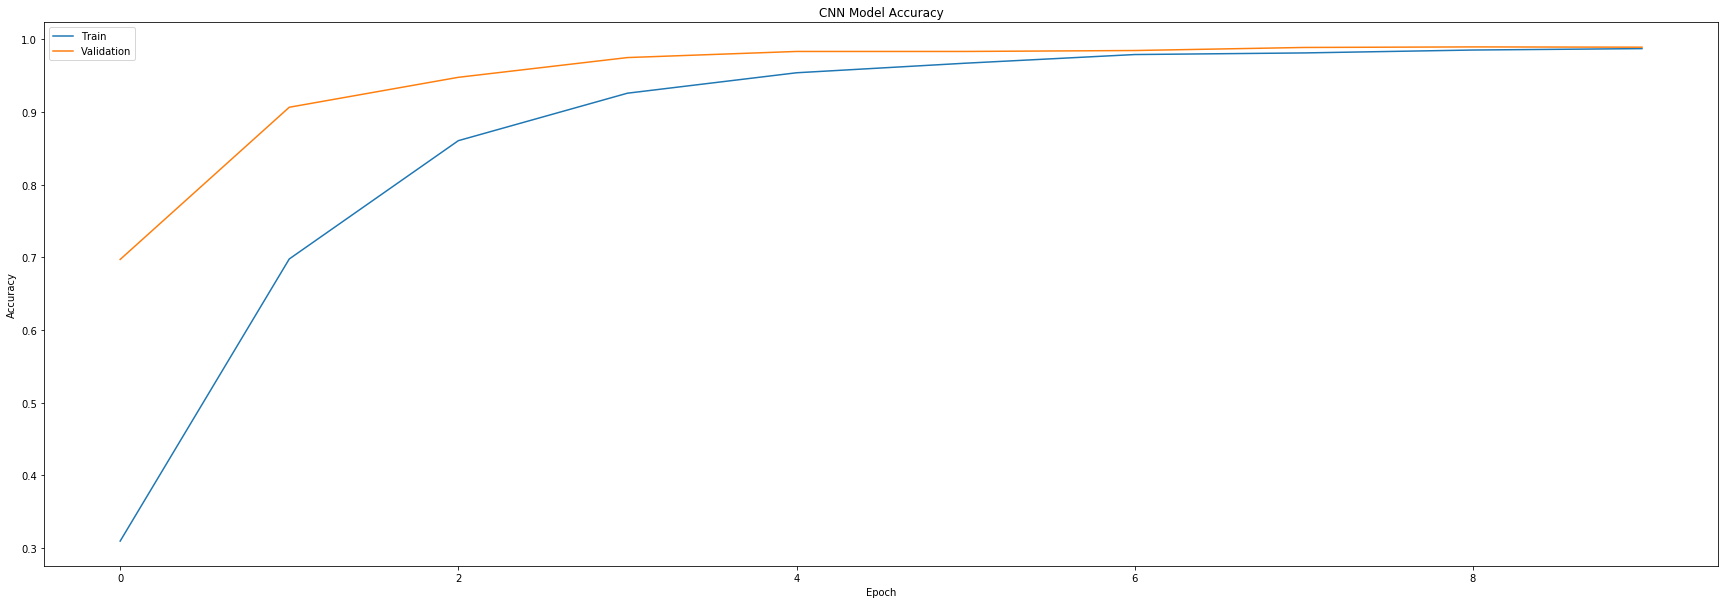

In [43]:
plt.figure(figsize = (30,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

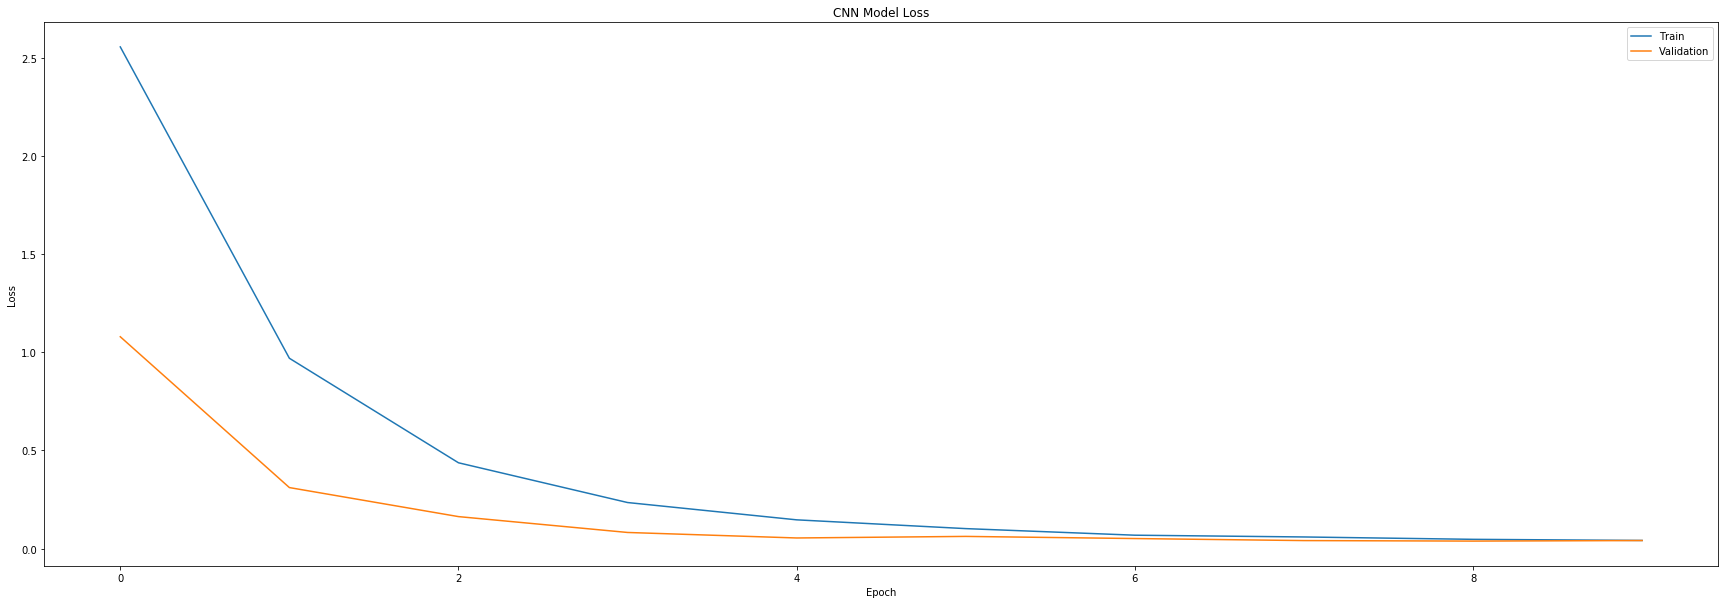

In [42]:
plt.figure(figsize = (30,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()


In [19]:
pred = model.predict_classes(test_x)

In [20]:
val_pred = model.predict_classes(val_x)
test_pred = model.predict_classes(test_x)

In [28]:
def fastest_argmax(array):
    array = list( array )
    return array.index(max(array))

In [48]:
y_val = []
y_test = []
y_train = []

for i in val_y:
    b = fastest_argmax(i)
    y_val.append(b)
    
for i in test_y:
    b = fastest_argmax(i)
    y_test.append(b)
    
for i in train1_y:
    b = fastest_argmax(i)
    y_train.append(b)

In [50]:
print("=========================== \n\n VALIDATION DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_val, val_pred))
print("\n\n========================== \n\n Accuracy Score\n\n", accuracy_score(y_val, val_pred))
print("\n\n========================== \n\n Classification Report\n\n", classification_report(y_val, val_pred))

print("=========================== \n\n TEST DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_test, test_pred))
print("\n\n========================== \n\n Accuracy Score\n\n",accuracy_score(y_test, test_pred))
print("\n\n========================== \n\n Classification Report\n\n",classification_report(y_test, test_pred))


 VALIDATION DATA METRICS



 Confusion Matrix

 [[ 42   0   1 ...   0   0   0]
 [  0 456   1 ...   0   0   1]
 [  0   1 464 ...   0   0   0]
 ...
 [  0   0   1 ...  81   0   0]
 [  0   0   0 ...   0  54   0]
 [  0   0   0 ...   0   0  50]]



 Accuracy Score

 0.9891609283346086



 Classification Report

               precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       1.00      0.99      0.99       462
           2       0.99      0.98      0.98       474
           3       0.97      0.99      0.98       264
           4       0.98      0.99      0.99       394
           5       0.97      0.96      0.97       359
           6       1.00      1.00      1.00        83
           7       0.98      0.97      0.97       301
           8       0.96      0.98      0.97       275
           9       1.00      1.00      1.00       279
          10       1.00      1.00      1.00       391
          11       1.00      0.99      0.9